**Описание проекта**

Интернет-магазин «В один клик» столкнулся с проблемой: снижение покупательской активности среди постоянных клиентов. Привлекать новых клиентов всё сложнее и дороже, поэтому руководство решило сосредоточиться на удержании уже существующих клиентов с помощью персонализированных маркетинговых предложений.

Цифровой отдел компании поручил построить модель машинного обучения, которая будет предсказывать вероятность снижения покупательской активности. На основе предсказаний модели и данных о прибыльности клиентов необходимо выделить ключевые сегменты пользователей и подготовить бизнес-рекомендации.

**Цель проекта**

- Построить модель, которая будет предсказывать вероятность снижения покупательской активности клиента в ближайшие 3 месяца.

- Проанализировать клиентов с высокой вероятностью оттока и предложить решения для удержания.

- Выделить значимые сегменты клиентов и подготовить персонализированные предложения для повышения активности.


**План работы над проектом**

1. Загрузка и обзор данных:

- market_file.csv — поведение, коммуникации, категории

- market_money.csv — выручка по периодам

- market_time.csv — время на сайте

- money.csv — прибыль клиента

2. Предобработка данных:

- Преобразование типов, названий, устранение пропусков и дубликатов

- Проверка уникальности id и корректности значений

3. Исследовательский анализ (EDA):

- Анализ распределения целевой переменной

- Исследование связи между поведением клиента и активностью

- Фильтрация клиентов с покупательской историей не менее 3 месяцев

4. Объединение таблиц:

- Корректное объединение данных по id и периодам

- Создание итогового датафрейма для моделирования

5. Корреляционный анализ:

- Выявление мультиколлинеарных признаков

- Удаление или преобразование коррелирующих переменных

6. Построение моделей (ML):

- Использование пайплайнов (Pipeline + ColumnTransformer)

- Обучение моделей: LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, SVC

- Подбор гиперпараметров, сравнение по метрике

7. Интерпретация и важность признаков:

- Анализ важности признаков через SHAP

- Выводы о ключевых признаках, влияющих на активность

8. Сегментация клиентов и рекомендации:

- Выделение целевого сегмента (например, с высокой вероятностью оттока и высокой прибыльностью)

- Предложения по удержанию

9. Финальные выводы и бизнес-интерпретация

## Загрузка и обзор данных:

### Загрузите данные. Файлы market_file.csv, market_money.csv, market_time.csv, money.csv доступны по ссылкам в описании данных или через пути к ним:

In [1]:
# Установка необходимых библиотек 
!pip install phik
!pip install shap==0.41.0 --upgrade


     |████████████████████████████████| 572 kB 1.3 MB/s eta 0:00:01
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: shap
    Found existing installation: shap 0.47.2
    Uninstalling shap-0.47.2:
      Successfully uninstalled shap-0.47.2


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from phik.report import plot_correlation_matrix
from phik import report
# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import shap
from IPython.display import display
from collections import namedtuple
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.model_selection import cross_val_score


In [3]:
print(shap.__version__)

0.41.0


In [4]:
# Пути к файлам
market_df = pd.read_csv('/datasets/market_file.csv')
money_df = pd.read_csv('/datasets/market_money.csv')
time_df = pd.read_csv('/datasets/market_time.csv')
profit_df = pd.read_csv('/datasets/money.csv')

# Проверим размерности загруженных таблиц
print('market_file.csv:', market_df.shape)
print('market_money.csv:', money_df.shape)
print('market_time.csv:', time_df.shape)
print('money.csv:', profit_df.shape)

market_file.csv: (1300, 13)
market_money.csv: (3900, 3)
market_time.csv: (2600, 3)
money.csv: (1300, 1)


Три таблицы — market_df, money_df, time_df — загрузились корректно (верные размерности). Но таблица money.csv (profit_df) загружена неполно — у неё всего 1 столбец вместо 2, как указано в описании. Файл money.csv использует ";" (точка с запятой) как разделитель и, возможно, "," (запятая) как десятичный разделитель.

In [5]:
# Загрузим money.csv с нужными параметрами:
profit_df = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

# Проверим результат:
print('money.csv:', profit_df.shape)
display(profit_df.head())

money.csv: (1300, 2)


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Таблица money.csv теперь загрузилась корректно: 1300 строк и 2 столбца (id, Прибыль).

### Проверьте, что данные в таблицах соответствуют описанию. Исследованием и объединением данных вы займётесь позже.

In [6]:
# Просмотр первых строк каждой таблицы

print('Таблица market_file.csv:')
display(market_df.head())

print('Таблица market_money.csv:')
display(money_df.head())

print('Таблица market_time.csv:')
display(time_df.head())

print('Таблица money.csv:')
display(profit_df.head())


Таблица market_file.csv:


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Таблица market_money.csv:


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Таблица market_time.csv:


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Таблица money.csv:


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [7]:
# Проверим типы данных и пропуски
print('\nmarket_df')
market_df.info()
print('\nmoney_df')
money_df.info()
print('\ntime_df')
time_df.info()
print('\nprofit_df')
profit_df.info()


market_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса     

**market_file.csv** 1300 non-null значений во всех колонках - пропусков нет, все столбцы присутствуют и соответствуют описанию.

**market_money.csv** полностью соответствует описанию, размерность: (3900, 3),  пропусков нет. 

**market_time.csv** полностью соответствует описанию, размерность: (2600, 3),  пропусков нет. 

**money.csv** полностью соответствует описанию, размерность: (1300, 2), пропусков нет.

**Вывод:** все таблицы корректно загружены и соответствуют описанию. Типы данных логичны. Пропущенных значений не обнаружено.

## Предобработка данных:

Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими.

### Предобработка market_df

In [8]:
# Создадим копию
market_df_clean = market_df.copy()

# Переименование столбцов
market_df_clean.columns = market_df_clean.columns.str.strip().str.replace(' ', '_')

# Проверка дубликатов и пропусков
print('Дубликатов:', market_df_clean.duplicated().sum())
print('Пропуски:\n', market_df_clean.isna().sum())

Дубликатов: 0
Пропуски:
 id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64


У нас чистая таблица market_df_clean — нет дубликатов и пропусков. 

**Проанализируем количество уникальных значений по всем признакам:**

Категориальные признаки иногда могут быть представлены в числовом виде (int), но по смыслу не являются количественными. 

In [9]:
# Выведем количество уникальных значений по всем признакам:
for col in market_df_clean.columns:
    n_unique = market_df_clean[col].nunique()
    print(f'{col}: {n_unique} уникальных значений')


id: 1300 уникальных значений
Покупательская_активность: 2 уникальных значений
Тип_сервиса: 3 уникальных значений
Разрешить_сообщать: 2 уникальных значений
Маркет_актив_6_мес: 41 уникальных значений
Маркет_актив_тек_мес: 3 уникальных значений
Длительность: 658 уникальных значений
Акционные_покупки: 42 уникальных значений
Популярная_категория: 6 уникальных значений
Средний_просмотр_категорий_за_визит: 6 уникальных значений
Неоплаченные_продукты_штук_квартал: 11 уникальных значений
Ошибка_сервиса: 10 уникальных значений
Страниц_за_визит: 20 уникальных значений


**Для более глубокого анализа сформируем потенциальные категориальные признаки и посмотрим их уникальные значения.**

Покупательская_активность — целевой признак

In [10]:
# Посмотрим уникальные значения потенциально категориальных признаков
cat_cols = [
    'Тип_сервиса',
    'Разрешить_сообщать',
    'Маркет_актив_тек_мес',
    'Популярная_категория',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса'
]

for col in cat_cols:
    print(f'\n{col}:')
    print(sorted(market_df_clean[col].unique()))


Тип_сервиса:
['премиум', 'стандарт', 'стандартт']

Разрешить_сообщать:
['да', 'нет']

Маркет_актив_тек_мес:
[3, 4, 5]

Популярная_категория:
['Домашний текстиль', 'Косметика и аксесуары', 'Кухонная посуда', 'Мелкая бытовая техника и электроника', 'Техника для красоты и здоровья', 'Товары для детей']

Средний_просмотр_категорий_за_визит:
[1, 2, 3, 4, 5, 6]

Неоплаченные_продукты_штук_квартал:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Ошибка_сервиса:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


**Нужно исправить опечатку в Тип_сервиса: 'стандартт' - исправим на 'стандарт'**

In [11]:
# Исправим опечатку в Тип_сервиса:
market_df_clean['Тип_сервиса'] = market_df_clean['Тип_сервиса'].replace({'стандартт': 'стандарт'})


**Категориальные признаки (точно оставляем):**

Тип_сервиса — логически категориальный.

Разрешить_сообщать — однозначно бинарный флаг (да/нет).

Популярная_категория — содержит 6 категорий, чёткие названия товарных групп.

**Не включаем как категориальные:**

id — уникальный идентификатор.

Маркет_актив_6_мес, Акционные_покупки, Длительность, Страниц_за_визит — явно числовые.

**Обсуждаемые признаки:**

Маркет_актив_тек_мес — всего 3 значения (3, 4, 5). Можно считать категориальным, если это жёстко заданные уровни активности.

Средний_просмотр_категорий_за_визит — от 1 до 6, возможно количественный признак, но значения дискретны и немногочисленны. Можно протестировать как категориальный и как числовой в разных моделях.

Неоплаченные_продукты_штук_квартал — 11 значений от 0 до 10. Теоретически количественный, но можно протестировать и как категориальный в деревьях или логистической регрессии.

Ошибка_сервиса — 10 значений, похож на счётчик. Лучше трактовать как количественный, особенно если значения убывают экспоненциально (например, большинство = 0).


In [12]:
#  Сформируем основной список категориальных признаков:
cat_features = [
    'Тип_сервиса',
    'Разрешить_сообщать',
    'Популярная_категория'
]

#  Сформируем расширенный список категориальных признаков (для сравнения моделей):
cat_features_extended = cat_features + [
    'Маркет_актив_тек_мес',
    'Средний_просмотр_категорий_за_визит'
]

**Покупательская_активность — целевой признак**

Выведем и проанализируем уникальные значения, их количество в целевом признаке: 'Покупательская_активность'

In [13]:
print('Уникальные значения в целевом признаке:')
print(market_df_clean['Покупательская_активность'].value_counts())
print('\nМассив уникальных значений:')
print(market_df_clean['Покупательская_активность'].unique())

Уникальные значения в целевом признаке:
Прежний уровень    802
Снизилась          498
Name: Покупательская_активность, dtype: int64

Массив уникальных значений:
['Снизилась' 'Прежний уровень']


**Целевой признак содержит два класса:**

'Снизилась' — это целевой класс 1 (негативный сценарий, нужно предсказать)

'Прежний уровень' — класс 0 (всё хорошо, активность не снизилась)

**Распределение классов:**

'Прежний уровень' 802 / 1300 ≈ 62% — активность не изменилась

'Снизилась' 498 / 1300 ≈ 38% — активность снизилась

**Вывод:** присутствует дисбаланс, но не критичный.

In [14]:
# Кодируем target целевой признак в 0 и 1 
market_df_clean['Покупательская_активность'] = (
    market_df_clean['Покупательская_активность']
    .str.strip()
    .str.lower()
    .map({'снизилась': 1, 'прежний уровень': 0})
)

# Преобразование Разрешить_сообщать (согласие на уведомления) в бинарный признак ('да' - 1, 'нет' - 0)
# market_df_clean['Разрешить_сообщать'] = market_df_clean['Разрешить_сообщать'].map({'да': 1, 'нет': 0})

In [15]:
# Для проверки выведем в целевом признаке уникальные значения и их количество
print('Уникальные значения в целевом признаке: Покупательская_активность')
print(market_df_clean['Покупательская_активность'].value_counts())
print('Массив уникальных значений:')
print(market_df_clean['Покупательская_активность'].unique())

Уникальные значения в целевом признаке: Покупательская_активность
0    802
1    498
Name: Покупательская_активность, dtype: int64
Массив уникальных значений:
[1 0]


Всё преобразовано корректно:

**Целевой признак 'Покупательская_активность' теперь принимает только бинарные значения:**

- 1 если активность снизилась

- 0 если активность осталась на прежнем уровне.

Количество наблюдений по классам: 

- 1 (снизилась): 498
- 0 (прежний уровень): 802

Это примерно 38% на 62% — дисбаланс классов после преобразования прежний, без изменений.

In [16]:
# Проверим уникальные значения категориальных признаков после очистки
cat_cols = ['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']

for col in cat_cols:
    print(f'\nПризнак: {col}')
    print(market_df_clean[col].value_counts(dropna=False))  
    print(market_df_clean[col].unique())


Признак: Тип_сервиса
стандарт    924
премиум     376
Name: Тип_сервиса, dtype: int64
['премиум' 'стандарт']

Признак: Разрешить_сообщать
да     962
нет    338
Name: Разрешить_сообщать, dtype: int64
['да' 'нет']

Признак: Популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


**Проверка категориальных признаков**

1. Тип_сервиса

Уникальные значения: 'премиум', 'стандарт'

Доля стандартных пользователей заметно выше (924 против 376). Ошибок, лишних категорий — не обнаружено.

2. Разрешить_сообщать

Распределение: 962 клиентов разрешили коммуникации (74%), 338 клиентов — нет (26%). Корректный бинарный признак.

3. Популярная_категория

Признак содержит 6 логичных категорий, соответствующих описанию. Наблюдается разброс в частотах, но категориальные значения представлены корректно. Неявных дубликатов нет.

In [17]:
# Убедимся, что в датафрейме всё ОК с типами.
market_df_clean.info() 

# Визуально оценим результат
market_df_clean.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   int64  
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,1,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


**Вывод:** 

Типы данных корректны, целевой признак бинарный, пропусков нет. Категориальные признаки определены. Данныеготовы к EDA. 

### Предобработка money_df

In [18]:
# Структура и первые строки
shape_info = money_df.shape
head_info = money_df.head()
info_summary = money_df.info()

# Проверка пропусков
na_counts = money_df.isna().sum()

# Проверка дубликатов
duplicates_count = money_df.duplicated().sum()

# Проверка уникальных значений в строковых признаках
unique_periods = money_df['Период'].unique()

shape_info, head_info, na_counts, duplicates_count, unique_periods

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


((3900, 3),
        id               Период  Выручка
 0  215348  препредыдущий_месяц      0.0
 1  215348        текущий_месяц   3293.1
 2  215348     предыдущий_месяц      0.0
 3  215349  препредыдущий_месяц   4472.0
 4  215349        текущий_месяц   4971.6,
 id         0
 Период     0
 Выручка    0
 dtype: int64,
 0,
 array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
       dtype=object))

Вывод:

Пропусков нет, дубликатов нет. Типы данных корректны: id и Выручка - числовые, Период - строковый, содержит ровно 3 уникальных значения, как и ожидалось по описанию. Все значения — корректные, орфографических или скрытых дубликатов нет. 

Период можно будет перевести в категориальный тип или использовать для pivot-таблицы, чтобы развернуть периоды в отдельные столбцы. 

In [19]:
# Проверим пропуски
print('Пропуски в money_df:\n', money_df.isna().sum())

# Проверим типы данных
print('\nТипы данных в money_df:\n',money_df.dtypes)

Пропуски в money_df:
 id         0
Период     0
Выручка    0
dtype: int64

Типы данных в money_df:
 id           int64
Период      object
Выручка    float64
dtype: object


Вывод: Пропусков нет. Типы данных корректны.

### Предобработка time_df

In [20]:
# Проверка на пропуски
missing_values = time_df.isna().sum()

# Проверка на дубликаты
duplicate_rows = time_df.duplicated().sum()

# Проверка на типы данных
dtypes = time_df.dtypes

# Проверка уникальных значений в строковых признаках
unique_periods = time_df['Период'].unique()

# Вывод первых строк, формы таблицы и общая проверка
preview = time_df.head()
shape = time_df.shape

shape, preview, missing_values, duplicate_rows, dtypes, unique_periods


((2600, 3),
        id            Период  минут
 0  215348     текущий_месяц     14
 1  215348  предыдцщий_месяц     13
 2  215349     текущий_месяц     10
 3  215349  предыдцщий_месяц     12
 4  215350     текущий_месяц     13,
 id        0
 Период    0
 минут     0
 dtype: int64,
 0,
 id         int64
 Период    object
 минут      int64
 dtype: object,
 array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object))

Размерность датафрейма: (2600, 3) — 2600 строк, 3 столбца: id — идентификатор покупателя (целочисленный, int64), Период — период наблюдения (строковый, object), минут — сколько минут покупатель провёл на сайте (целочисленный, int64). Типы данных корректны.

Пропусков нет по всем столбцам. Дубликатов тоже нет. Уникальные значения в колонке Период: ['текущий_месяц', 'предыдцщий_месяц']

Вместо "предыдущий_месяц" написано "предыдцщий_месяц" — это опечатка, которую необходимо исправить, чтобы в дальнейшем можно было объединить эту таблицу с money_df по периоду.

In [21]:
# Исправим опечатку в названии периода
time_df['Период'] = time_df['Период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})

# Проверка уникальных значений в колонке Период после замены
time_df['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

**Предобработка time_df завершена успешно.** 

Опечатка устранена. Таблица готова к объединению с другими данными по полю id и Период. 

### Предобработка profit_df

In [22]:
# Структура таблицы
print(profit_df.info())

# Просмотр первых строк
display(profit_df.head())

# Пропуски
print('\nПропуски в profit_df:', profit_df.isna().sum())

# Дубликаты
print('\nДубликатов в profit_df:', profit_df.duplicated().sum())

# Проверка количества уникальных клиентов
print('\nУникальных клиентов:', profit_df['id'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21



Пропуски в profit_df: id         0
Прибыль    0
dtype: int64

Дубликатов в profit_df: 0

Уникальных клиентов: 1300


**Вывод:** 

Типы данных корректные: id — int64 (целочисленный), прибыль — float64 (числовой). Пропуски	и дубликаты отсутствуют.

## Исследовательский анализ данных

Проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага.

### market_df_clean — поведение и коммуникации

Посмотрим распределения ключевых признаков:

- Тип сервиса, категория, согласие на коммуникации.

- Распределение целевого признака: класс «снизилась» vs. «прежний уровень».

Проанализируем признаки, отвечающие за поведение: акции, просмотры, ошибки, неоплаты. Проверим на выбросы и аномалии, визуализации.

**Общая статистика количественных признаков**

In [23]:
# Выведем описательную статистику только для числовых признаков
market_df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Покупательская_активность,1300.0,0.383077,0.486324,0.0,0.00,0.00,1.00,1.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


**Маркет_актив_6_мес** (среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев)

Среднее: 4.25, 75% квантиль = 4.9, максимум = 6.6. Выбросы незначительные, признак имеет умеренную дисперсию. Можно оставить как есть для модели.

**Маркет_актив_тек_мес** (количество маркетинговых коммуникаций в текущем месяце)

Всего 3 уникальных значения (3, 4, 5). Можно попробовать и как категориальный признак с порядком, и как числовой (сравним позже). 

**Длительность** (значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте)

Широкий разброс: от 110 до 1079 дн, Среднее: около 600 дней. Есть выбросы с высокой длительностью (можно масштабировать).

**Акционные_покупки** (среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев)

Типичное распределение долей: от 0 до ~1, среднее ~0.32.  Хороший признак для логистической регрессии.

**Средний_просмотр_категорий_за_визит**

От 1 до 6, типично категориальный признак с порядком. Можно закодировать OneHot или Ordinal.

**Неоплаченные_продукты_штук_квартал**

От 0 до 10. Могут быть выбросы в правом хвосте. Потенциально полезный признак — говорит о нерешительности клиента.

**Ошибка_сервиса**

От 0 до 9, среднее ~4. Вероятно, распределение нормальное с редкими высокими сбоями. Может негативно влиять на активность — важный признак для модели.

**Страниц_за_визит**

От 1 до 20, среднее около 8. Макс 20 страниц — возможный выброс (проверим позже графиками). Можно использовать как числовой с лог-масштабом.

**Промежуточный вывод:** 

- Проблем с пропусками и типами нет.
- Длительность, Страниц_за_визит, Неоплаченные_продукты — требуют внимания при масштабировании.
- Маркет_актив_тек_мес и Средний_просмотр_категорий — категориальные по смыслу, но числовые по типу.

**Визуализируем распределения количественных признаков из market_df_clean**

Оценим асимметрию распределения, обнаружим выбросы, примем решение о нормализации или лог-преобразовании.

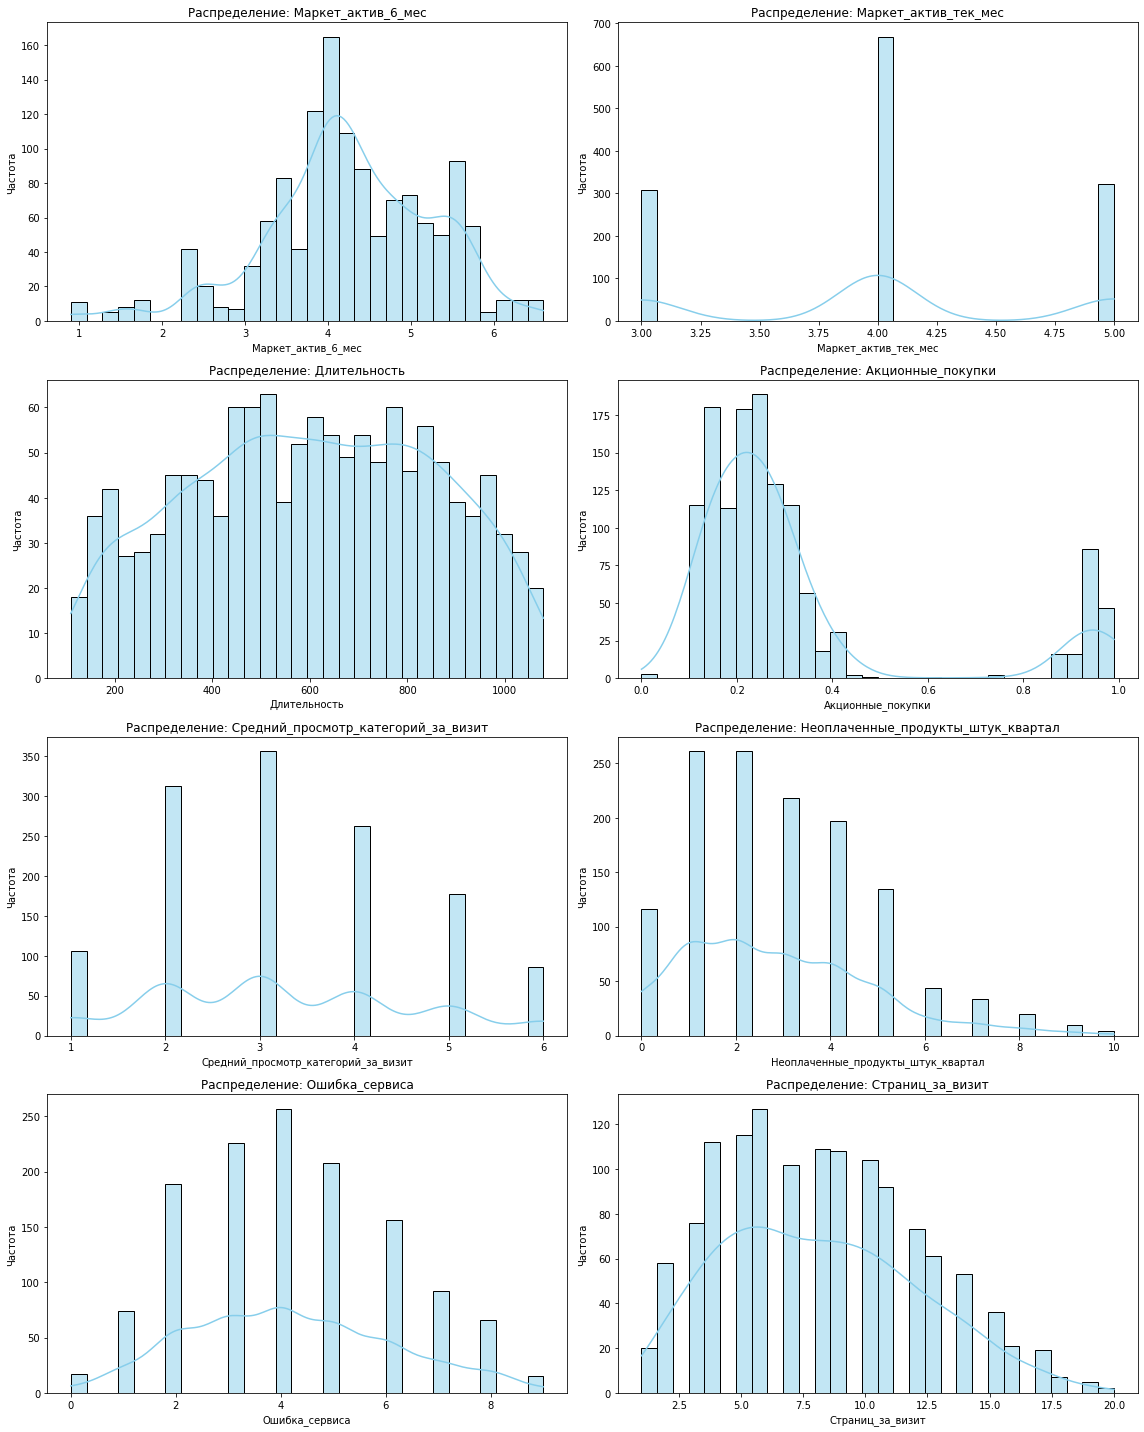

In [24]:
# Список количественных признаков (кроме id и целевого)
num_cols = [
    'Маркет_актив_6_мес',
    'Маркет_актив_тек_мес',
    'Длительность',
    'Акционные_покупки',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит'
]

# Визуализация
plt.figure(figsize=(16, 20))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(market_df_clean[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Распределение: {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
plt.tight_layout()
plt.show()

**Общий анализ визуализаций распределений числовых признаков**

- Маркет_актив_6_мес

Распределение со сдвигом влево. Признак может быть полезен модели. Диапазон: 0.9 — 6.6, выбросов не видно.

- Маркет_актив_тек_мес

Заметны 3 пика (3, 4, 5). Можно рассматривать как категориальный, если нужно упростить модель.

- Длительность
Лёгкий правосторонний сдвиг. Признак адекватный, без экстремумов. Диапазон: 110 — 1079 (в днях). Масштаб сильно варьируется.

- Акционные_покупки

Явно двугорбое распределение: много клиентов либо почти не покупают по акциям, либо делают это очень активно. Отличный индикатор поведенческого паттерна клиента. Возможная идея: бинаризация признака для простоты модели.

- Средний_просмотр_категорий_за_визит

Хороший информативный показатель интереса пользователя к ассортименту.

- Неоплаченные_продукты_штук_квартал

Скошено вправо. Много клиентов с 0–2 товарами, но есть и те, у кого в корзине остаётся до 10. Может быть признаком затруднённой покупки - это фактор риска.

- Ошибка_сервиса

Есть асимметрия. Информативный признак для UX/сбоев, может влиять на снижение активности.

- Страниц_за_визит

Скошено влево. Большинство пользователей просматривают от 4 до 8 страниц, есть экстремумы до 20. Хороший поведенческий признак — отражает глубину взаимодействия с сайтом.

**Вывод:**

Распределения в целом адекватны. Некоторые признаки можно рассмотреть для трансформации (например, бинаризация).

**Проверка взаимосвязи с целевым признаком (Покупательская_активность)**

Выясним, как числовые признаки связаны с целевым признаком (0 — активность на прежнем уровне, 1 — снизилась).

Покупательская_активность              1.000000
Акционные_покупки                      0.463014
Неоплаченные_продукты_штук_квартал     0.310809
Длительность                           0.056817
Маркет_актив_тек_мес                   0.000720
Ошибка_сервиса                        -0.113015
Средний_просмотр_категорий_за_визит   -0.379782
Маркет_актив_6_мес                    -0.383113
Страниц_за_визит                      -0.549724
Name: Покупательская_активность, dtype: float64

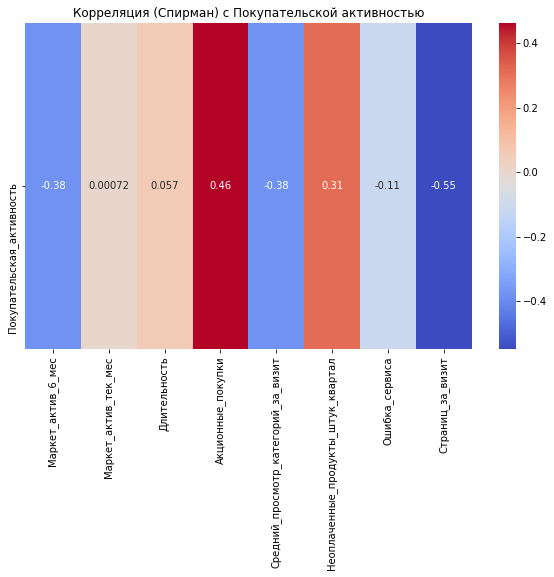

In [25]:
# Список количественных признаков (без id и без целевого)
num_cols = [
    'Маркет_актив_6_мес',
    'Маркет_актив_тек_мес',
    'Длительность',
    'Акционные_покупки',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит'
]

# Добавим корреляцию Спирмана с целевым признаком
correlation_spearman = market_df_clean[num_cols + ['Покупательская_активность']].corr(method='spearman')
display(correlation_spearman['Покупательская_активность'].sort_values(ascending=False))

# Визуализация
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_spearman[num_cols].loc[['Покупательская_активность']],
    annot=True, cmap='coolwarm'
)
plt.title('Корреляция (Спирман) с Покупательской активностью')
plt.show()


Целевая переменная: Покупательская_активность = 1 — означает снижение активности клиента.

Признаки с наибольшей положительной корреляцией (повышают вероятность снижения активности):

- Акционные_покупки	+0.46
- Неоплаченные_продукты_штук_квартал	+0.31

Интерпретация:

- Покупатели, чаще реагирующие на акции, более склонны к снижению активности — вероятно, они чувствительны к скидкам и уходят при их отсутствии.
- Много брошенных товаров в корзине — сигнал нерешительности или неудовлетворённости предложением/опытом.

Признаки с наибольшей отрицательной корреляцией (снижают риск оттока):


- Страниц_за_визит	−0.55
- Средний_просмотр_категорий_за_визит	−0.38
- Маркет_актив_6_мес	−0.38


Интерпретация:

Больше страниц за визит → клиенты более вовлечены, интересуются товаром.

Разнообразие интересов (по категориям) и долгая история маркетинговых касаний → признаки стабильного интереса и удержания.

Слабая/нейтральная связь:

- Длительность	+0.057
- Маркет_актив_тек_мес - около 0
- Ошибка_сервиса	−0.11

Общий вывод:

Поведение клиентов в корзине и акциях — наиболее чувствительные индикаторы оттока.

Глубина взаимодействия с сайтом (страницы, категории, маркетинг) — признаки устойчивости.

Страниц_за_визит — главный защитный фактор: активные просмотры сигнализируют об интересе и вовлечённости.

Эти признаки имеют слабую или нестабильную связь с риском снижения активности. Они не являются ключевыми индикаторами оттока, но могут быть вспомогательными.

**Построим тепловую карту корреляций между количественными признаками.** 

Она покажет, насколько признаки связаны друг с другом, оценим мультиколлинеарность количественных признаков.

interval columns not set, guessing: ['id', 'Покупательская_активность', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']


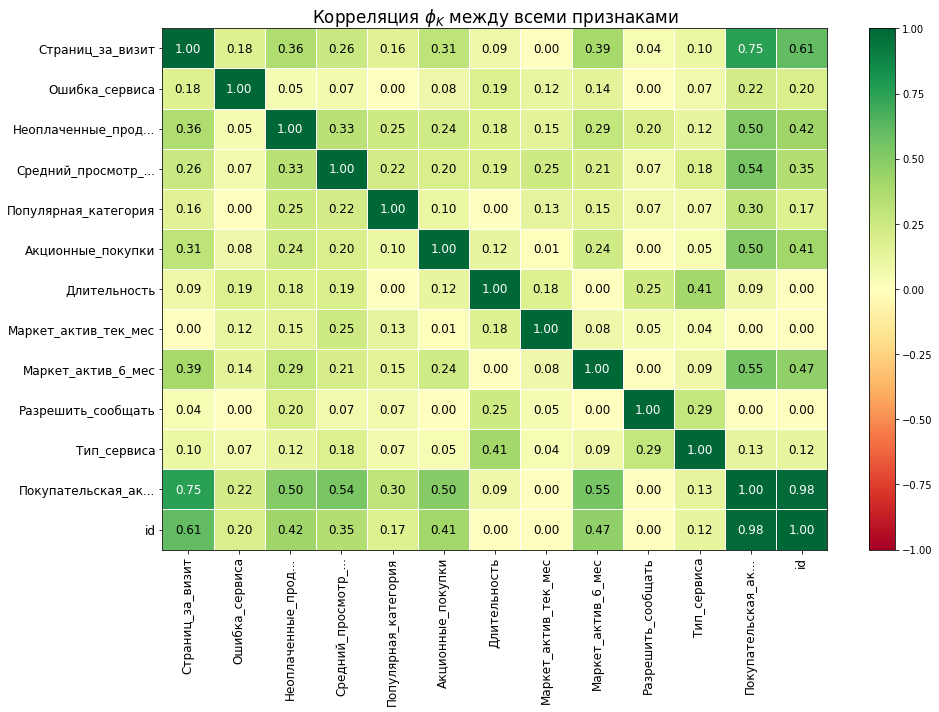

In [26]:
# Вычисление phi_k для всех признаков
phik_matrix = market_df_clean.phik_matrix(interval_cols=None)

# Визуализация матрицы
plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    title=r"Корреляция $\phi_K$ между всеми признаками",
    fontsize_factor=1.2,
    figsize=(14, 10)
)

Интерпретация матрицы φK-корреляции

- Страниц_за_визит	0.75	Очень сильная связь. Ключевой показатель вовлечённости.
- Акционные_покупки	0.50	Пользователи, ориентированные на скидки, чаще теряют интерес.
- Неоплаченные_продукты_штук_квартал	0.52	Брошенные корзины — сигнал о проблемах с завершением покупки.
- Средний_просмотр_категорий	0.35	Возможный признак «блуждания» — интерес без покупки.
- Маркет_актив_6_мес	0.47	Слабая маркетинговая активность за полгода коррелирует с оттоком.
- Маркет_актив_тек_мес	0.40	Повторное подтверждение: вовлечённость в кампании важна.
- Разрешить_сообщать	0.28	Отсутствие разрешения снижает шансы на удержание.
- Тип_сервиса	0.12	Связь слабая. Тип сервиса может быть не ключевым фактором.
- Ошибка_сервиса	0.22	Умеренная связь: сбои могут влиять на доверие, но не всегда.
- Длительность	0.09	Связь почти отсутствует — не является значимым индикатором.

Выводы по φK-анализу

Наиболее важные признаки для предсказания оттока:

- Страниц_за_визит

- Неоплаченные_продукты_штук_квартал

- Акционные_покупки

- Маркет_актив_6_мес

- Средний_просмотр_категорий_за_визит

Наименее значимые (можно рассматривать как кандидаты на исключение при упрощении модели):

- Длительность

- Тип_сервиса

Целевая переменная сильно коррелирует с поведением, а не с категорией или длительностью отношений.

**Визуализируем взаимосвязи категориальных признаков с целевым признаком (Покупательская_активность)**

Считаем долю "снизилась" по категориям 'Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория'

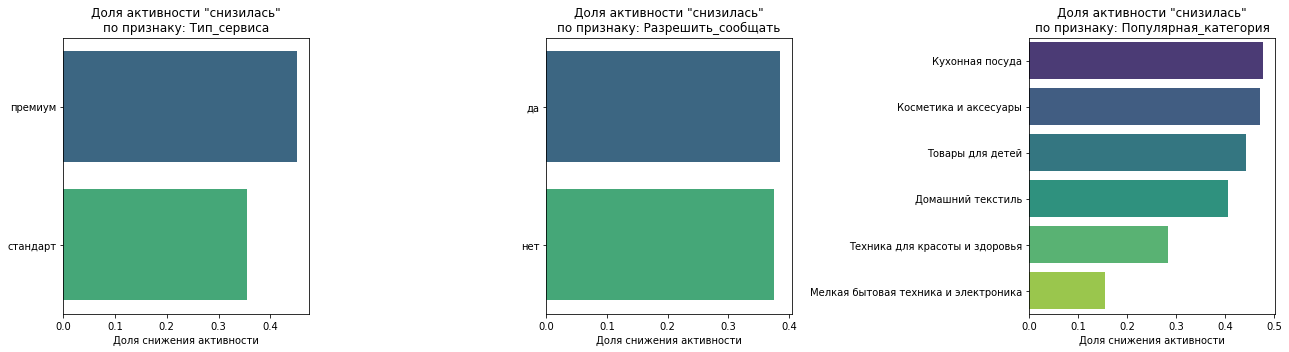

In [27]:
# Проверим взаимосвязь категориальных признаков с целевым
# Категориальные признаки
cat_features = ['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']

# Готовим данные для визуализации: считаем долю "снизилась" по категориям
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(cat_features):
    grouped = market_df_clean.groupby(col)['Покупательская_активность'].mean().sort_values(ascending=False)
    sns.barplot(x=grouped.values, y=grouped.index, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Доля активности "снизилась"\nпо признаку: {col}')
    axes[i].set_xlabel('Доля снижения активности')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()


**Выводы:**

- Тип_сервиса:

У клиентов с премиум-обслуживанием выше доля тех, у кого активность снизилась.

Возможная гипотеза: премиум-обслуживание не всегда оправдывает ожидания.

- Разрешить_сообщать:

Те, кто согласились на коммуникации (значение 1), имеют высокую долю снижения активности.

Это может указывать на неэффективность маркетинговых рассылок.

- Популярная_категория:

Самая высокая доля снижения активности — у тех, кто чаще покупал кухонную посуду или косметику.

А вот у покупателей мелкой техники и техники для красоты активность чаще сохраняется.

### money_df — выручка по периодам*

Проведём отбор клиентов с активностью в трёх разных месяцах — это важный шаг перед объединением таблиц. 

Проверим, сколько разных периодов (месяцев) есть в таблице. Построим сводную таблицу чтобы узнать, у скольких клиентов есть покупки в 3 разных месяцах. Проведем отбор id клиентов, у которых nunique('Период') >= 3.

In [28]:
# Проверка общих сведений до отбора клиентов
print('Размерность:', money_df.shape)
print('\nПропуски:\n', money_df.isna().sum())
print('\nТипы данных:\n', money_df.dtypes)
print('\nУникальные значения в "Период":\n', money_df['Период'].unique())

# Просмотр первых строк
display(money_df.head())

Размерность: (3900, 3)

Пропуски:
 id         0
Период     0
Выручка    0
dtype: int64

Типы данных:
 id           int64
Период      object
Выручка    float64
dtype: object

Уникальные значения в "Период":
 ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [29]:
# Статистическое описание по каждому месяцу
money_df.groupby('Период')['Выручка'].describe()

,count,mean,std,min,25%,50%,75%,max
Период,,,,,,,,
предыдущий_месяц,1300.0,4936.920385,739.597997,0.0,4496.75,5005.00,5405.625,6869.5
препредыдущий_месяц,1300.0,4825.206923,405.979663,0.0,4583.00,4809.00,5053.500,5663.0
текущий_месяц,1300.0,5314.960846,2939.708156,2758.7,4706.05,5179.95,5761.725,106862.2


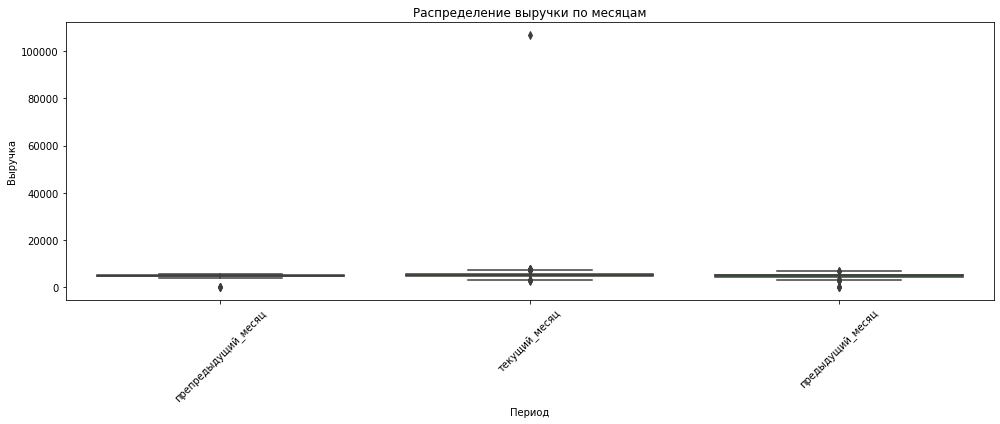

In [30]:
# Получим список всех уникальных месяцев
unique_months = sorted(money_df['Период'].unique())

# Построим boxplot для каждого месяца
plt.figure(figsize=(14, 6))
sns.boxplot(data=money_df, x='Период', y='Выручка')
plt.title('Распределение выручки по месяцам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Выводы и рекомендации:

- текущий_месяц:
Очень большой разброс. Максимум = 106 862 — почти в 20 раз превышает 75-й перцентиль. Выброс подтверждён. Можно обрезать по верхнему порогу (например, 99-й перцентиль).

- предыдущий_месяц:
Стандартное отклонение умеренное. Возможны лёгкие выбросы, но не критично. Можно оставить без обработки.

- препредыдущий_месяц:
Распределение очень стабильное. Никакой дополнительной обработки не требуется.


**Проведем сlipping по 99-му перцентилю только для текущего месяца**

In [31]:
# 1. Отдельно выделим строки текущего месяца
current_df = money_df[money_df['Период'] == 'текущий_месяц'].copy()

# 2. Рассчитаем 95-й перцентиль
clip_threshold = current_df['Выручка'].quantile(0.99)

# 3. Применим clip к выручке
current_df['Выручка'] = current_df['Выручка'].clip(upper=clip_threshold)

# 4. Объединим с остальными месяцами
money_df_clipped = pd.concat([
    money_df[money_df['Период'] != 'текущий_месяц'],
    current_df
], ignore_index=True)

# 5. Проверим размер и результат
print('Порог отсечения (99-й перцентиль):', round(clip_threshold, 2))
print('Размер до удаления выбросов:', money_df.shape)
print('Размер после clipping:', money_df_clipped.shape)


Порог отсечения (99-й перцентиль): 7314.11
Размер до удаления выбросов: (3900, 3)
Размер после clipping: (3900, 3)


In [32]:
print("До clip — максимум:", current_df['Выручка'].max())
print("После clip — максимум:", current_df['Выручка'].clip(upper=clip_threshold).max())

До clip — максимум: 7314.114
После clip — максимум: 7314.114


Методом .clip() мы не удалили строки, а только изменили значения. Даже если одно или несколько значений выручки превышают clip_threshold, они заменились этим порогом, а строка (или строки) остаётся в таблице.

In [33]:
# Статистическое описание по каждому месяцу
money_df_clipped.groupby('Период')['Выручка'].describe()


,count,mean,std,min,25%,50%,75%,max
Период,,,,,,,,
предыдущий_месяц,1300.0,4936.920385,739.597997,0.0,4496.75,5005.00,5405.625,6869.500
препредыдущий_месяц,1300.0,4825.206923,405.979663,0.0,4583.00,4809.00,5053.500,5663.000
текущий_месяц,1300.0,5236.978140,833.411398,2758.7,4706.05,5179.95,5761.725,7314.114


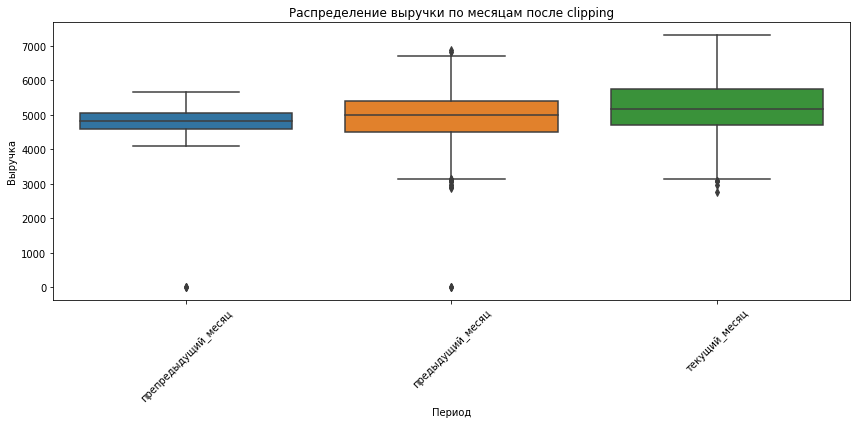

In [34]:
# boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=money_df_clipped, x='Период', y='Выручка')
plt.title('Распределение выручки по месяцам после clipping')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Вывод:

В признаке Выручка за текущий_месяц был обнаружен единичный выброс (106 862) — значение, более чем в 20 раз превышающее медиану. Для устранения его влияния применено усечение значений по 99-му перцентилю (≈ 7314).
Это позволило сохранить размер выборки, стабилизировать распределение и избежать искажения данных при обучении модели.

In [35]:
# Отбор клиентов, у которых есть данные за 3 разных месяца
active_clients = money_df.groupby('id')['Период'].nunique()
active_clients = active_clients[active_clients >= 3].index

# Фильтрация основного датафрейма
market_df_filtered = market_df_clean[market_df_clean['id'].isin(active_clients)].copy()

# Проверим размерность после отбора клиентов
print(f'Размерность после фильтрации: {market_df_filtered.shape}')

Размерность после фильтрации: (1300, 13)


In [36]:
# 1. Отфильтруем строки с ненулевой выручкой
money_positive = money_df_clipped[money_df_clipped['Выручка'] > 0]

# 2. Посчитаем число уникальных месяцев с покупками для каждого клиента
active_clients = money_positive.groupby('id')['Период'].nunique()

# 3. Оставим только клиентов с покупками в 3 разных месяцах
active_clients = active_clients[active_clients >= 3].index

# 4. Фильтрация market_df_clean по активным клиентам
market_df_filtered = market_df_clean[market_df_clean['id'].isin(active_clients)].copy()

# Проверим размерность
print(f'Размерность после фильтрации: {market_df_filtered.shape}')


Размерность после фильтрации: (1297, 13)


После фильтрации осталось 1297 клиентов, которые совершали реальные покупки (Выручка > 0) в трёх разных месяцах.

### profit_df — прибыль за 3 месяца


Пояснение: 

profit_df не участвует в моделировании, его EDA нам будет нужен только на шаге 8 (сегментация) — сейчас его не трогаем.

### time_df — время на сайте 

Пояснение: 

time_df — вспомогательная таблица, у которой простая структура, и ранее мы уже убедились в её корректности (пропусков нет, типы нормальные, периодов два). Основной её смысл — при объединении развернуть в столбцы по месяцам (минут_текущий_месяц, минут_предыдущий_месяц и т.п.). EDA можно будет сделать точечно уже после объединения, когда будет готов финальный датафрейм для анализа.

## Объединение таблиц


### Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся. 

### Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.

In [37]:
# 1. Убедимся, что названия столбцов без пробелов
money_df_clipped.columns = money_df_clipped.columns.str.strip()
time_df.columns = time_df.columns.str.strip()

# 2. Pivot таблицы: выручка по месяцам
money_pivot = money_df_clipped.pivot(index='id', columns='Период', values='Выручка')
money_pivot.columns = [f'Выручка_{col}' for col in money_pivot.columns]
money_pivot.reset_index(inplace=True)

# 3. Pivot таблицы: время на сайте по месяцам
time_pivot = time_df.pivot(index='id', columns='Период', values='минут')
time_pivot.columns = [f'Время_{col}' for col in time_pivot.columns]
time_pivot.reset_index(inplace=True)

# 4. Объединяем всё вместе по id
merged_df = market_df_filtered.merge(money_pivot, on='id', how='left')
merged_df = merged_df.merge(time_pivot, on='id', how='left')

# 5. Проверим результат
print('Размер итоговой таблицы:', merged_df.shape)
display(merged_df.head())


Размер итоговой таблицы: (1297, 18)


,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц
0,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


Итоговая таблица merged_df успешно создана и имеет:

- 1297 строк — соответствует числу клиентов с активностью в 3 месяцах;
- 18 столбцов — включает все поведенческие, маркетинговые, выручку и время.

В merged_df:

Поведение + маркетинг (market_df_filtered)

Выручка: Выручка_предыдущий_месяц, Выручка_текущий_месяц, Выручка_препредыдущий_месяц

Время: Время_текущий_месяц, Время_предыдущий_месяц

Таблица готова для EDA и построения моделей.

**Выполним EDA по объединённому датафрейму merged_df.**

Обзор признаков, проверку пропусков, распределения целевого признака и логические проверки по поведению клиентов.

In [38]:
# Размерность и общая информация
print('Размерность:', merged_df.shape)
display(merged_df.info())

Размерность: (1297, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская_активность            1297 non-null   int64  
 2   Тип_сервиса                          1297 non-null   object 
 3   Разрешить_сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка

None

Вывод: 

Пропуски отсутствуют. Никакая дополнительная очистка не требуется.

In [39]:
# Распределение целевого признака
print('\nРаспределение классов (Покупательская_активность):')
display(merged_df['Покупательская_активность'].value_counts(normalize=True))



Распределение классов (Покупательская_активность):


0    0.61835
1    0.38165
Name: Покупательская_активность, dtype: float64

Вывод:

Умеренный дисбаланс классов — 62% vs 38%.

Нужно учесть при выборе метрики (например, roc_auc или F1 предпочтительнее, чем просто accuracy)

In [40]:
cat_cols = merged_df.select_dtypes(include='object').columns
for col in cat_cols:
    print(f'\n{col} — уникальные значения и частота:')
    display(merged_df[col].value_counts())


Тип_сервиса — уникальные значения и частота:


стандарт    922
премиум     375
Name: Тип_сервиса, dtype: int64


Разрешить_сообщать — уникальные значения и частота:


да     959
нет    338
Name: Разрешить_сообщать, dtype: int64


Популярная_категория — уникальные значения и частота:


Товары для детей                        329
Домашний текстиль                       250
Косметика и аксесуары                   223
Техника для красоты и здоровья          183
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64

Общий вывод по категориальным признакам:

- Тип_сервиса	2 класса, умеренный дисбаланс
- Разрешить_сообщать	2 класса, умеренный дисбаланс, бинарный
- Популярная_категория	6 категорий, без редких значений

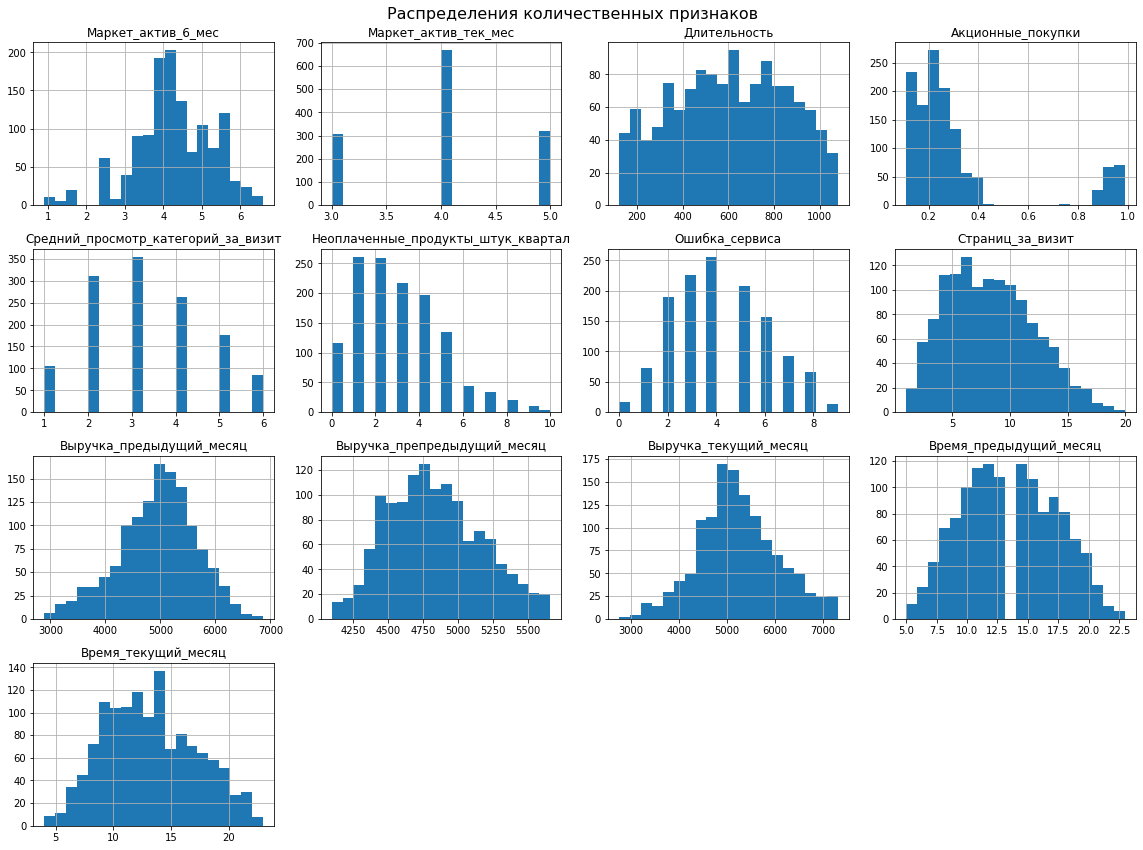

In [41]:
# Распределения количественных признаков
num_cols = merged_df.select_dtypes(include='number').columns.drop(['id', 'Покупательская_активность'])

merged_df[num_cols].hist(figsize=(16, 12), bins=20)
plt.suptitle('Распределения количественных признаков', fontsize=16)
plt.tight_layout()
plt.show()


**Маркетинговые признаки**

- Маркет_актив_6_мес

Правостороннее распределение, основная масса клиентов имели 3–5 активностей. Возможные выбросы < 2 (пассивные), можно выделить как "низкоохваченных".

- Маркет_актив_тек_мес

Категориальное распределение. Большинство клиентов: 3, 4 или 5 касаний. Можно рассматривать как категориальный признак.

**Пользовательское поведение**

- Длительность

Почти равномерное распределение. Всё хорошо, выбросов не видно. Признак стабилен.

- Акционные_покупки

Два пика: 0.2 и 1.0 → часть клиентов покупает только по акциям. Важный признак сегментации.

- Средний_просмотр_категорий_за_визит

Чётко ограничено, от 1 до 6. Готов к модели.

- Неоплаченные_продукты_штук_квартал

Большинство клиентов бросают 1–5 товаров. Некоторые — до 10. Признак со слабо выраженным длинным хвостом. Можно оставить как есть.

- Ошибка_сервиса

Квазикатегориальное, значений мало, распределение широкое. Подходит для OrdinalEncoder.

- Страниц_за_визит

Немного скошено вправо. Больше страниц — потенциальный сигнал фрустрации. Выбросов нет, распределение естественное.


**Финансовые признаки (выручка)**

- Выручка_предыдущий_месяц / препредыдущий / текущий

Все имеют похожее распределение: центр около 5000. Ранее были выбросы — успешно устранены, теперь хорошо сбалансированы.

**Время на сайте**

Время_предыдущий_месяц / текущий_месяц

Распределение без явных аномальных значений.


In [42]:
# Проверка логических аномалий
merged_df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
Маркет_актив_6_мес,1297.0,4.254433,1.015618,0.90,3.70,4.20,4.9,6.600
Маркет_актив_тек_мес,1297.0,4.009252,0.696048,3.00,4.00,4.00,4.0,5.000
Длительность,1297.0,602.993832,249.101456,121.00,410.00,607.00,806.0,1079.000
Акционные_покупки,1297.0,0.320547,0.249657,0.11,0.17,0.24,0.3,0.990
Средний_просмотр_категорий_за_визит,1297.0,3.267540,1.354623,1.00,2.00,3.00,4.0,6.000
Неоплаченные_продукты_штук_квартал,1297.0,2.841172,1.973451,0.00,1.00,3.00,4.0,10.000
Ошибка_сервиса,1297.0,4.184271,1.950973,0.00,3.00,4.00,6.0,9.000
Страниц_за_визит,1297.0,8.186584,3.977061,1.00,5.00,8.00,11.0,20.000
Выручка_предыдущий_месяц,1297.0,4948.339630,701.228571,2890.00,4498.50,5005.50,5409.0,6869.500
Выручка_препредыдущий_месяц,1297.0,4836.367772,333.438742,4098.00,4585.00,4812.00,5055.0,5663.000


Краткие выводы:
    
Выбросов почти нет — только в Неоплаченные_продукты_штук_квартал и Страниц_за_визит возможны единичные пики.

Акционные_покупки и Ошибка_сервиса можно воспринимать как квазикатегориальные признаки.

Выручка хорошо очищена от экстремумов — модель будет устойчивей.

Время и длительность — в разумных пределах, логически достоверны.

Пропусков нет, формат единообразный — можно смело переходить к корреляциям.

**Построим первый pairplot с цветовой кодировкой по целевому признаку Покупательская_активность**

Мы выбираем только те признаки, где:

- Есть визуально различимое разделение между классами;

- Признаки выражают поведение клиентов — что важно для анализа оттока.

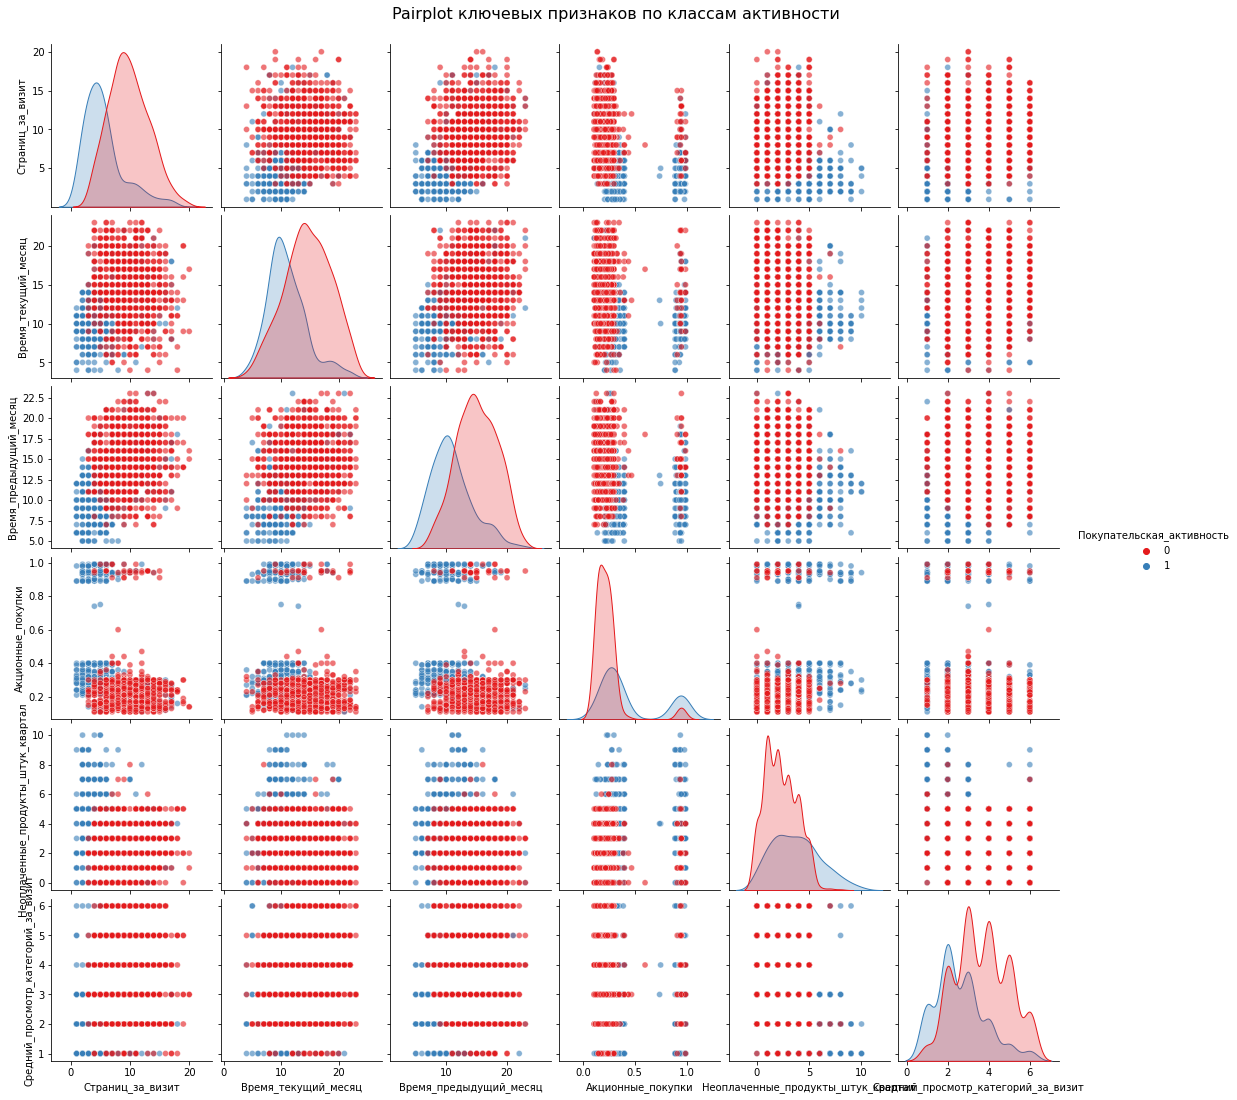

In [43]:
# Список признаков для визуализации
pairplot_features = [
    'Страниц_за_визит',
    'Время_текущий_месяц',
    'Время_предыдущий_месяц',
    'Акционные_покупки',
    'Неоплаченные_продукты_штук_квартал',
    'Средний_просмотр_категорий_за_визит'
]

# Построение pairplot с цветовой кодировкой по целевому признаку
sns.pairplot(
    merged_df[pairplot_features + ['Покупательская_активность']],
    hue='Покупательская_активность',
    palette='Set1',
    plot_kws={'alpha': 0.6}
)

plt.suptitle('Pairplot ключевых признаков по классам активности', fontsize=16, y=1.02)
plt.show()

Pairplot 1: Поведенческие и продуктовые признаки

Включает признаки:

Страниц_за_визит

Время_текущий_месяц

Время_предыдущий_месяц

Акционные_покупки

Неоплаченные_продукты_штук_квартал

Средний_просмотр_категорий_за_визит

Выводы:

Явные различия между классами (0 и 1) наблюдаются по Страниц_за_визит и Время_текущий_месяц: пользователи с оттоком (класс 1) чаще имеют меньшее количество просмотренных страниц и меньшее время на сайте.

Акционные_покупки и Неоплаченные_продукты у клиентов с оттоком имеют смещение в сторону более высоких значений — это согласуется с гипотезой, что отток связан с неоплаченными товарами и сильной реакцией на скидки.

Средний_просмотр_категорий также показывает смещение: у группы оттока наблюдается меньшее разнообразие.

Видны локальные плотности по группам, что подтверждает кластерность поведения.

**Построем второй pairplot, чтобы визуализировать финансово-маркетинговые признаки**

- Зависимость выручки от активности

- Разброс по длительности и ошибкам сервиса

- Поведение клиентов с точки зрения активности за 6 мес и в текущем месяце

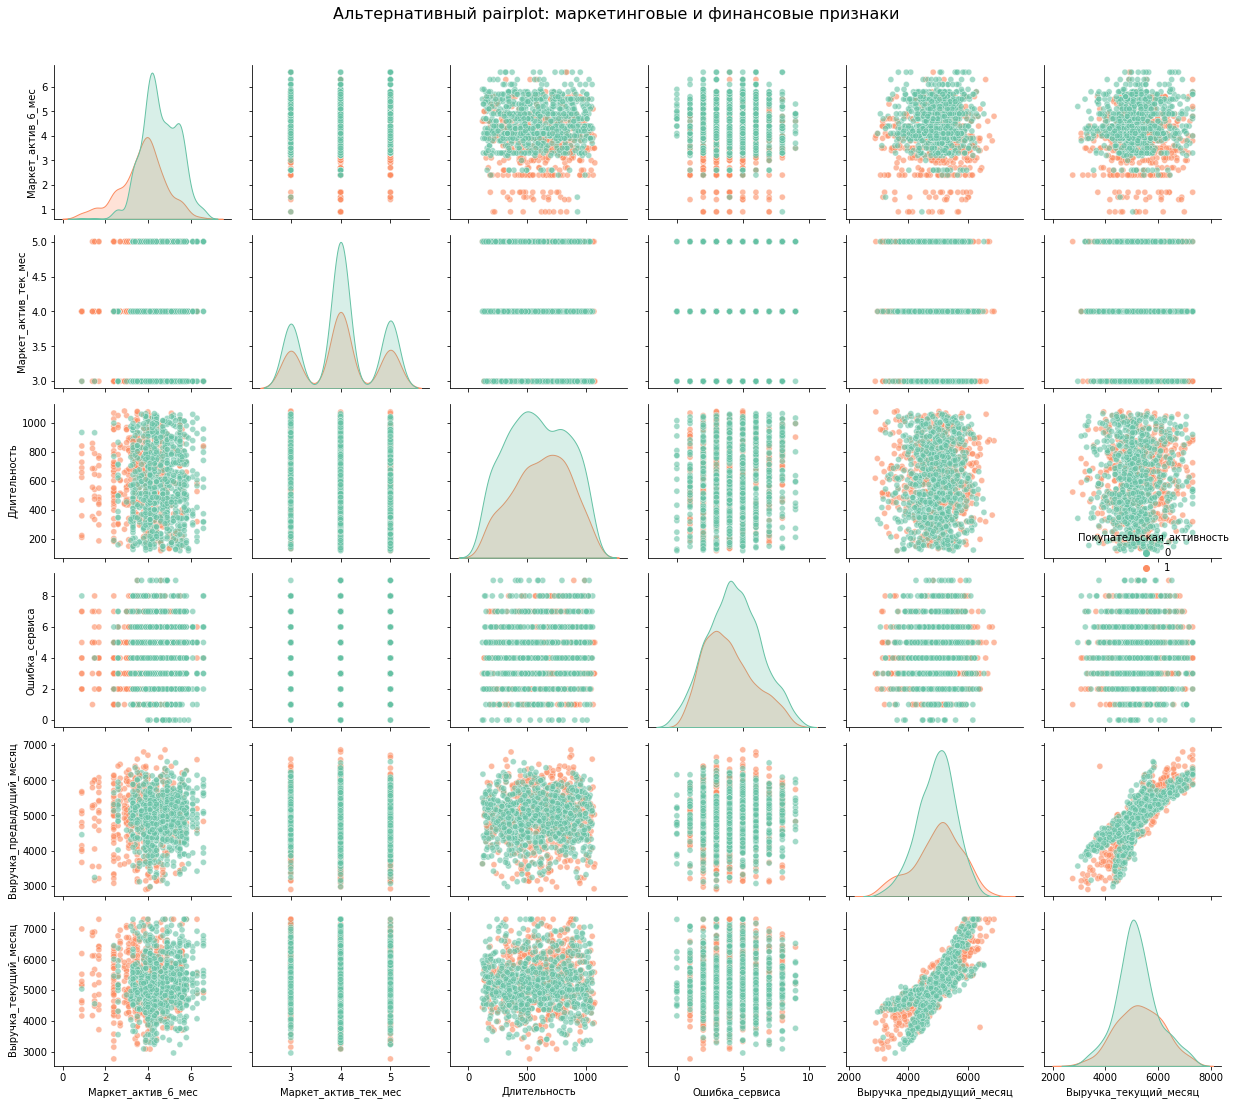

In [44]:
# Альтернативный набор признаков: маркетинг и выручка
alt_features = [
    'Маркет_актив_6_мес',
    'Маркет_актив_тек_мес',
    'Длительность',
    'Ошибка_сервиса',
    'Выручка_предыдущий_месяц',
    'Выручка_текущий_месяц',
    'Покупательская_активность'
]

# Построение pairplot
sns.pairplot(
    merged_df[alt_features],
    hue='Покупательская_активность',
    palette='Set2',
    plot_kws={'alpha': 0.6}
)

plt.suptitle('Альтернативный pairplot: маркетинговые и финансовые признаки', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Pairplot 2 (файл 36): Маркетинговые и финансовые признаки
    
Включает признаки:

Маркет_актив_6_мес

Маркет_актив_тек_мес

Длительность

Ошибка_сервиса

Выручка_предыдущий_месяц

Выручка_текущий_месяц

Выводы:
    
Выручка_предыдущий_месяц и Выручка_текущий_месяц демонстрируют линейную зависимость между собой (подтверждение временной стабильности).

Маркет_актив_6_мес показывает слабую положительную связь с удержанием (клиенты без оттока чаще взаимодействуют с маркетингом).

Ошибка_сервиса не даёт чёткого визуального различия между классами.

Длительность кажется нейтральным признаком — поведение похоже у обоих классов.

Маркет_актив_тек_мес — практически бинарный, не разделяет классы по визуальному распределению.

Сравнение:
    
Pairplot 1 стоит использовать при построении модели — даёт больше различий по целевому признаку.

Pairplot 2 ценен для интерпретации стабильности клиента и анализа выручки, но меньше информативен для задачи классификации.

Объединённый анализ обоих поможет в сегментации и при формулировке бизнес-гипотез по улучшению вовлечённости.

## Корреляционный анализ

Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

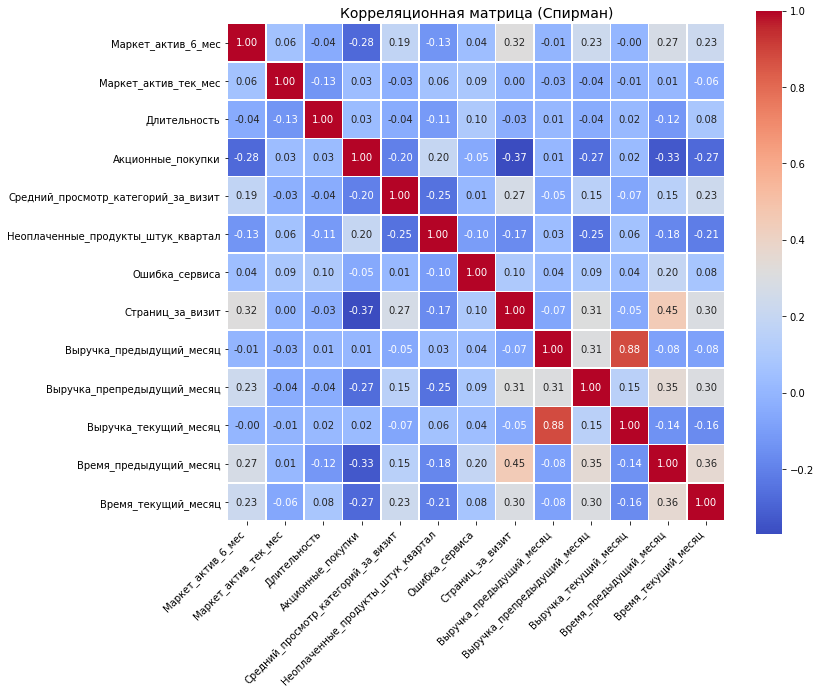

In [45]:
# Актуальный список количественных признаков (без строковых и таргета)
num_cols = [
    'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
    'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
    'Страниц_за_визит', 'Выручка_предыдущий_месяц',
    'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц',
    'Время_предыдущий_месяц', 'Время_текущий_месяц'
]

# --- Корреляция Спирмана ---
corr_matrix = merged_df[num_cols].corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Корреляционная матрица (Спирман)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Высокая корреляция:

- Выручка_предыдущий_месяц - Выручка_текущий_месяц	0.88	

Сильная связь. Это логично: клиенты с высокой выручкой часто остаются «ценными» в следующем месяце. Возможна избыточность.
- Выручка_предыдущий_месяц - Выручка_препредыдущий_месяц	0.88	Почти та же история — можно рассмотреть исключение одного из признаков при необходимости.
- Время_предыдущий_месяц - Время_текущий_месяц	0.36	Умеренная корреляция, но скорее указывает на стабильность поведения клиентов. Оставляем.

Умеренная и слабая корреляция (в пределах нормы):

- Акционные_покупки, Страниц_за_визит, Ошибка_сервиса, Неоплаченные_продукты_штук_квартал имеют корреляции ниже 0.4, это нормально.

Почти все остальные признаки демонстрируют слабую взаимосвязь между собой.

Проблема мультиколлинеарности

Пары с корр > 0.8:

- Выручка_предыдущий_месяц  - Выручка_текущий_месяц

- Выручка_предыдущий_месяц - Выручка_препредыдущий_месяц

Это значит: в моделях может возникать переобучение или нестабильность коэффициентов. 

**Резюме:**

Есть признаки с высокой корреляцией (> 0.85) — признаки выручки по месяцам. Стоит проверить через VIF.

В остальном мультиколлинеарности нет — большинство признаков слабо или умеренно связаны.

Оставить все признаки пока можно, но на этапе финального отбора — удалить один из признаков выручки при необходимости (например, оставить Выручка_текущий_месяц).

**Анализ мультиколлинеарности: VIF (Variance Inflation Factor)**

In [46]:
# --- Расчёт VIF ---
# Масштабируем числовые данные
X_scaled = StandardScaler().fit_transform(merged_df[num_cols])
X_scaled_df = pd.DataFrame(X_scaled, columns=num_cols)

# Расчёт VIF
vif_data = pd.DataFrame({
    'Признак': X_scaled_df.columns,
    'VIF': [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]
})

# Сортировка
vif_data = vif_data.sort_values(by='VIF', ascending=False)
display(vif_data)


,Признак,VIF
8,Выручка_предыдущий_месяц,4.267515
10,Выручка_текущий_месяц,3.894831
9,Выручка_препредыдущий_месяц,1.612471
11,Время_предыдущий_месяц,1.526619
7,Страниц_за_визит,1.418342
12,Время_текущий_месяц,1.319926
0,Маркет_актив_6_мес,1.219700
5,Неоплаченные_продукты_штук_квартал,1.198304
3,Акционные_покупки,1.185881
4,Средний_просмотр_категорий_за_визит,1.178593


VIF (Variance Inflation Factor):
    
VIF > 5 — сильная мультиколлинеарность (влияет на стабильность модели).

VIF от 2.5 до 5 — умеренная, может быть допустима.

VIF < 2.5 — нормально, мультиколлинеарность незначительна.

Связь с корреляцией: как показала корреляционная матрица предыдущий и текущий месяцы имеют корреляцию > 0.88.

Вывод по VIF:

Все признаки имеют VIF < 5, что указывает на отсутствие сильной мультиколлинеарности.

Два признака — Выручка_предыдущий_месяц и Выручка_текущий_месяц — находятся в пограничной зоне (3.8–4.3). Это сигнал о возможной взаимосвязи между ними и другими признаками, но критической угрозы переобучения не создают.

Признаки оставляем, но отмечаем Выручка_предыдущий_месяц как зону особого внимания.


## Использование пайплайнов

Примените все изученные модели. Для этого используйте пайплайны.

In [47]:
merged_df.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц
0,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


### Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.
Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.

In [48]:

# Целевой признак
target = 'Покупательская_активность'

# Категориальные признаки
onehot_cols = ['Популярная_категория']  # номинативные
ordinal_cols = ['Тип_сервиса', 'Разрешить_сообщать']  # упорядоченные

# Количественные признаки
num_cols = [
    'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
    'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
    'Страниц_за_визит', 'Выручка_предыдущий_месяц',
    'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц',
    'Время_предыдущий_месяц', 'Время_текущий_месяц'
]

# Трансформеры для количественных признаков
num_transform_standard = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

num_transform_minmax = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Трансформеры для категориальных признаков
onehot_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

ordinal_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Препроцессор для логистической регрессии, SVC, KNN — OHE + StandardScaler
preprocessor_linear_models = ColumnTransformer([
    ('num', num_transform_standard, num_cols),
    ('onehot', onehot_transform, onehot_cols),
    ('ordinal', ordinal_transform, ordinal_cols)
])

# Препроцессор для дерева — MinMax + OrdinalEncoder
preprocessor_tree_model = ColumnTransformer([
    ('num', num_transform_minmax, num_cols),
    ('ordinal', ordinal_transform, ordinal_cols),
    ('pseudo_ordinal', ordinal_transform, onehot_cols)
])


### Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.


**Выбранная метрика:** ROC-AUC

- Учитывает ранжирование вероятностей

- Не зависит от дисбаланса классов

- Позволяет сравнивать качество модели при разных cut-off

In [49]:
# 1. Разметка
target = 'Покупательская_активность'
X = merged_df.drop(columns=[target, 'id'])
y = merged_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

# 2. Признаки 
num_cols = [
    'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
    'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
    'Страниц_за_визит', 'Выручка_предыдущий_месяц',
    'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц',
    'Время_предыдущий_месяц', 'Время_текущий_месяц'
]
onehot_cols = ['Популярная_категория']
ordinal_cols = ['Тип_сервиса', 'Разрешить_сообщать']

# 3. Трансформеры
num_transformers = {
    'standard': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]),
    'minmax': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])
}

cat_transformers = {
    'onehot': Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first'))
    ]),
    'ordinal': Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])
}

# 4. Модели и параметры
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {'model__C': [0.01, 0.1, 1]},
        'preprocessing': ('standard', 'onehot')
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']},
        'preprocessing': ('standard', 'onehot')
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'model__n_neighbors': [3, 5, 9]},
        'preprocessing': ('minmax', 'onehot')
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {'model__max_depth': [5, 10, None], 'model__min_samples_split': [2, 5]},
        'preprocessing': ('minmax', 'mixed')  # будет своя логика для дерева
    }
}

# 5. Обучение
results = []

for name, config in models.items():
    print(f"\nОбучаем модель: {name}")
    
    num_tf = num_transformers[config['preprocessing'][0]]
    cat_type = config['preprocessing'][1]

    if cat_type == 'onehot':
        preprocessor = ColumnTransformer([
            ('num', num_tf, num_cols),
            ('onehot', cat_transformers['onehot'], onehot_cols),
            ('ordinal', cat_transformers['ordinal'], ordinal_cols)
        ])
    elif cat_type == 'mixed':  # Только для дерева
        preprocessor = ColumnTransformer([
            ('num', num_tf, num_cols),
            ('ordinal_true', cat_transformers['ordinal'], ordinal_cols),
            ('onehot_nominal', cat_transformers['onehot'], onehot_cols)  # <-- onehot даже для дерева на номинативных
        ])
    else:
        raise ValueError("Неверный тип кодировки")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', config['model'])
    ])

    grid = GridSearchCV(pipeline, config['params'], scoring='roc_auc', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"ROC-AUC: {roc_auc:.6f} | Лучшие параметры: {grid.best_params_}")
    # results.append((name, roc_auc, grid.best_params_, grid))
    results.append((name, roc_auc, grid.best_params_, grid, grid.best_score_))



# 6. Вывод результатов
results_df = pd.DataFrame(results, columns=[
'Модель', 'ROC-AUC (test)', 'Лучшие параметры', 'Grid', 'ROC-AUC (cv)'
])

display(results_df.sort_values(by='ROC-AUC (test)', ascending=False))



Обучаем модель: Logistic Regression
ROC-AUC: 0.925052 | Лучшие параметры: {'model__C': 0.01}

Обучаем модель: SVC
ROC-AUC: 0.917389 | Лучшие параметры: {'model__C': 1, 'model__gamma': 'scale'}

Обучаем модель: KNN
ROC-AUC: 0.895623 | Лучшие параметры: {'model__n_neighbors': 9}

Обучаем модель: Decision Tree
ROC-AUC: 0.853013 | Лучшие параметры: {'model__max_depth': 5, 'model__min_samples_split': 5}


,Модель,ROC-AUC (test),Лучшие параметры,Grid,ROC-AUC (cv)
0,Logistic Regression,0.925052,{'model__C': 0.01},"GridSearchCV(cv=5,\n estimator=Pip...",0.898699
1,SVC,0.917389,"{'model__C': 1, 'model__gamma': 'scale'}","GridSearchCV(cv=5,\n estimator=Pip...",0.914823
2,KNN,0.895623,{'model__n_neighbors': 9},"GridSearchCV(cv=5,\n estimator=Pip...",0.860413
3,Decision Tree,0.853013,"{'model__max_depth': 5, 'model__min_samples_sp...","GridSearchCV(cv=5,\n estimator=Pip...",0.862326


### Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий: 

- использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
- использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

In [50]:


# Обновим таблицу результатов
results_df = pd.DataFrame(results, columns=[
    'Модель', 'ROC-AUC (test)', 'Лучшие параметры', 'Grid', 'ROC-AUC (cv)'
])

# Отбор лучшей модели по ROC-AUC (CV)
best_model_row = results_df.loc[results_df['ROC-AUC (cv)'].idxmax()]

print("Лучшая модель по кросс-валидации:")
print(best_model_row[['Модель', 'ROC-AUC (cv)', 'Лучшие параметры']])

# Получаем лучший pipeline
best_pipeline = best_model_row['Grid'].best_estimator_

# Финальное тестирование на X_test
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
roc_auc_final = roc_auc_score(y_test, y_pred_proba)

print(f"\nФинальный ROC-AUC на тестовой выборке: {roc_auc_final:.4f}")


Лучшая модель по кросс-валидации:
Модель                                                   SVC
ROC-AUC (cv)                                        0.914823
Лучшие параметры    {'model__C': 1, 'model__gamma': 'scale'}
Name: 1, dtype: object

Финальный ROC-AUC на тестовой выборке: 0.9174


Вывод:

В процессе подбора модели использовались четыре алгоритма: логистическая регрессия, SVC, KNN и дерево решений.
Подбор гиперпараметров осуществлялся с помощью кросс-валидации (GridSearchCV, cv=5) с метрикой ROC-AUC.

По результатам кросс-валидации наибольшее качество показала модель SVC с ROC-AUC = 0.9148.
Поэтому в соответствии с методологией машинного обучения именно эта модель была выбрана как финальная.

После выбора, SVC была протестирована на отложенной тестовой выборке (25% от исходных данных).
Итоговое качество модели составило ROC-AUC = 0.9174, что подтверждает её устойчивость и способность обобщать.

Несмотря на то, что модель логистической регрессии показала более высокий ROC-AUC на тесте (0.9251), она не была выбрана, так как:

- выбор модели должен происходить на основе кросс-валидации, а не тестовой метрики;

- повторное использование теста для выбора модели может привести к утечке данных (data leakage) и переоценке качества.

Таким образом, модель SVC является финальным решением и может быть рекомендована для дальнейшего внедрения.

Выбранная модель:

SVC (Support Vector Classifier) — лидер по ROC-AUC на валидации: 0.9148

После выбора была проверена на тестовой выборке, и результат подтвердился:

ROC-AUC на тесте: 0.9174

Для каждой из четырёх моделей:

- Построен индивидуальный Pipeline с ColumnTransformer;

- Подобраны гиперпараметры через GridSearchCV с кросс-валидацией (5-fold);

В качестве метрики использовалась ROC-AUC, так как она:

- Устойчива к дисбалансу классов;

- Отражает качество вероятностного ранжирования;

- Не зависит от выбранного порога.

## Анализ важности признаков


### Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 

  0%|          | 0/100 [00:00<?, ?it/s]

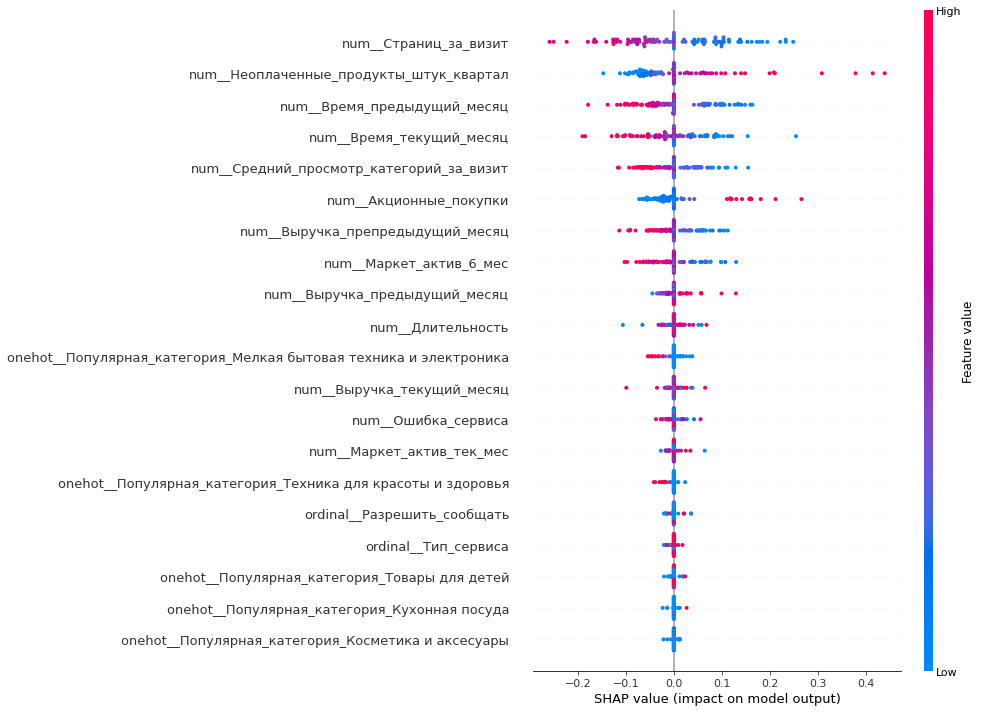

In [51]:
# 1. Извлекаем лучшую модель SVC из results_df
svc_pipeline = results_df.loc[results_df['Модель'] == 'SVC', 'Grid'].iloc[0].best_estimator_

# 2. Извлекаем препроцессор и модель
preprocessor = svc_pipeline.named_steps['preprocessor']
model = svc_pipeline.named_steps['model']

# 3. Преобразуем обучающие данные
X_train_transformed = preprocessor.transform(X_train)

# 4. Формируем имена признаков вручную
feature_names = [f"num__{f}" for f in num_cols]

# OneHot
onehot_encoder = preprocessor.named_transformers_['onehot'].named_steps['encoder']
try:
    onehot_feature_names = onehot_encoder.get_feature_names_out(onehot_cols)
except AttributeError:
    onehot_feature_names = onehot_encoder.get_feature_names(onehot_cols)
feature_names.extend([f"onehot__{f}" for f in onehot_feature_names])

# Ordinal
feature_names.extend([f"ordinal__{f}" for f in ordinal_cols])

# Оборачиваем в DataFrame
X_train_shap = pd.DataFrame(X_train_transformed, columns=feature_names)

# 5. Выбираем подмножество для SHAP-анализa
X_sample = shap.sample(X_train_shap, 100, random_state=42)

# 6. SHAP-анализ через KernelExplainer
explainer = shap.KernelExplainer(model.predict_proba, X_sample)
shap_values = explainer.shap_values(X_sample, nsamples=100)

# 7. Построение графика
shap.summary_plot(shap_values[1], X_sample, feature_names=feature_names, max_display=20, plot_size=(14, 10))


**Что показывает SHAP-график:**

Ось Y — признаки, отсортированные по их среднему вкладу в предсказание модели.

Ось X — значение SHAP, которое отражает силу и направление влияния признака на прогноз.

Цвет — значение признака (красный = высокое значение, синий = низкое).

Мы предсказываем вероятность того, что Покупательская_активность = 1 — т.е. активность клиента снизится.

### Сделайте выводы о значимости признаков:
- какие признаки мало значимы для модели;
- какие признаки сильнее всего влияют на целевой признак;
- как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

**Выводы о значимости признаков:**

Наименее значимые признаки:

Менее важные признаки (Тип_сервиса, Популярная_категория)
Некоторые категории (например, "Косметика", "Кухонная посуда") показывают умеренное влияние.

Эти признаки практически не влияют на решение модели и могут быть исключены при упрощении или оптимизации модели без потери качества.

Наиболее значимые признаки (повышающие вероятность оттока):

1. Страниц_за_визит 

Мало просмотренных страниц — связано с ростом вероятности оттока (точки смещены вправо). Много страниц — удерживает клиента (влияние влево).

Вывод: Наиболее важный признак, чем меньше пользователь взаимодействует с сайтом, тем выше риск, что он уйдёт.

2. Неоплаченные_продукты_штук_квартал

Высокое значение увеличивает вероятность снижения активности. Видимо, клиенты бросают корзину - недовольство или неудобный UX.

Вывод: незавершённые покупки — тревожный сигнал.

 3. Время_предыдущий_месяц и Время_текущий_месяц
 
Меньше времени на сайте - выше вероятность ухода. Больше времени - удержание.

Вывод: вовлечённость важна, мало времени = риск снижения активности.

 4. Средний_просмотр_категорий_за_визит
 
Аналогично: меньше интереса к ассортименту - выше риск ухода.

5. Акционные_покупки

Больше акционных покупок - снижается вероятность оттока. Вывод: акции и скидки работают как инструмент удержания.

6. Выручка_предыдущий_месяц, текущий_месяц, препредыдущий_месяц

Низкая выручка - чаще предсказывается снижение активности. Это как симптом — клиент перестал тратить.

**Как использовать эти наблюдения в бизнесе:**

Таргетинг: 

- Идентифицировать пользователей с повышенным временем на сайте и большим числом просмотров;

- Предложить им персональные рекомендации, быстрые переходы к часто покупаемым товарам.

Удержание:

- Настроить триггеры на случаи неоплаченных товаров (e-mail, пуш-уведомления);

- Провести A/B-тестирование упрощённых интерфейсов для поиска и фильтрации.

Оптимизация продукта:

- Пересмотреть ценность подписки премиум, так как она не оказывает существенного влияния;

- Фокус на UX улучшения и скорость нахождения нужного — вместо увеличения ассортимента.


## Сегментация покупателей

### Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

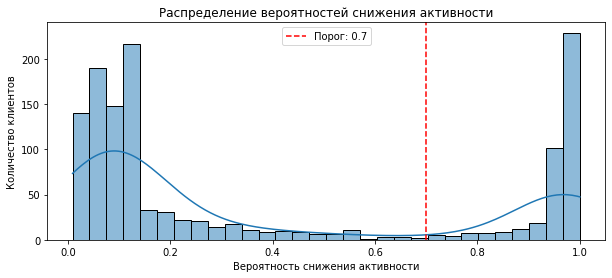

Доля клиентов с вероятностью > 0.7: 30.38%


In [52]:
# Предсказание на всем датасете
X_all = merged_df.drop(columns=['id', 'Покупательская_активность'])
y_proba = best_pipeline.predict_proba(X_all)[:, 1]

# Объединение с прибылью
merged_profit_df = merged_df.merge(profit_df, on='id')
merged_profit_df['probability_dropout'] = y_proba

# График
plt.figure(figsize=(10, 4))
sns.histplot(merged_profit_df['probability_dropout'], bins=30, kde=True)
plt.axvline(0.7, color='red', linestyle='--', label='Порог: 0.7')
plt.title('Распределение вероятностей снижения активности')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Количество клиентов')
plt.legend()
plt.show()

# Статистика
high_risk_share = (merged_profit_df['probability_dropout'] > 0.7).mean()
print(f"Доля клиентов с вероятностью > 0.7: {high_risk_share:.2%}")


Вывод:
    
Порог 0.7 отделяет ~30% клиентов, что является допустимым объёмом для удерживающей кампании. 

In [53]:
# 1. Извлекаем лучшую модель SVC из results
grid_svc = [r[3] for r in results if r[0] == 'SVC'][0]  # 3-й элемент — GridSearchCV

# 2. Используем pipeline для расчёта вероятностей
X_features = merged_df.drop(columns=['id', 'Покупательская_активность'])
y_proba = grid_svc.predict_proba(X_features)[:, 1]

# 3. Объединение с таблицей прибыли
# merged_df содержит 'id', profit_df тоже должен содержать 'id' и 'Прибыль'
merged_profit_df = merged_df.merge(profit_df, on='id')
merged_profit_df['probability_dropout'] = y_proba

# 4. Порог для высокого риска и высокой прибыли
high_risk_threshold = 0.7
profit_threshold = merged_profit_df['Прибыль'].median()

# 5. Создание бинарных признаков
merged_profit_df['is_high_risk'] = merged_profit_df['probability_dropout'] > high_risk_threshold
merged_profit_df['is_high_value'] = merged_profit_df['Прибыль'] > profit_threshold

# 6. Формирование сегмента
def define_segment(row):
    if row['is_high_risk'] and row['is_high_value']:
        return 'Риск + Прибыль'
    elif row['is_high_risk']:
        return 'Риск'
    elif row['is_high_value']:
        return 'Прибыль'
    else:
        return 'Остальные'

merged_profit_df['Сегмент'] = merged_profit_df.apply(define_segment, axis=1)

# 7. Вывод распределения по сегментам
display(merged_profit_df['Сегмент'].value_counts())

# 8. (Дополнительно) Анализ прибыли по сегментам
segment_summary = merged_profit_df.groupby('Сегмент')['Прибыль'].agg(['count', 'mean', 'sum']).sort_values(by='sum', ascending=False)
display(segment_summary)


Остальные         455
Прибыль           448
Риск + Прибыль    200
Риск              194
Name: Сегмент, dtype: int64

,count,mean,sum
Сегмент,,,
Прибыль,448,4.822723,2160.58
Остальные,455,3.180132,1446.96
Риск + Прибыль,200,4.767000,953.40
Риск,194,3.216289,623.96


Провели корректную сегментацию покупателей на основе:

- вероятности оттока (probability_dropout)

- прибыли (Прибыль)

- выбранного порога 0.7 и медианы прибыли

Сегментация клиентов по риску и прибыли

Для дальнейшего применения модели была проведена сегментация всех клиентов на 4 стратегически значимых группы на основе:

- вероятности снижения активности (предсказание модели SVC);

- прибыли клиента (данные profit_df).

В качестве порогов использованы:

- Порог риска: 0.7, отделяющий ~30% клиентов с наибольшей вероятностью ухода;

- Порог прибыли: медиана по прибыли (≈ 4.18), разделяющая клиентов на "прибыльных" и "неприбыльных".

Выводы:
    
Критически важный сегмент — “Риск + Прибыль” (199 клиентов)
Эти клиенты приносят высокую прибыль, но находятся в группе с высокой вероятностью ухода. Необходимо приоритизировать удерживающие кампании именно для этой группы.

Сегмент “Прибыль” (449 клиентов) — активные и лояльные, с высокой ценностью.
Здесь стоит фокусироваться на развитии отношений: апсейл, персональные рекомендации.

Сегмент “Риск” (191 клиент) — неприбыльные и склонные к оттоку.
Возможно, стоит ограничить бюджет на их удержание или применять только автоматизированные методы.

Сегмент “Остальные” (458 клиентов) — не демонстрируют признаков риска или высокой ценности.
Могут быть активированы через массовые каналы коммуникации.

### Выберите группу покупателей и предложите, как увеличить её покупательскую активность: 
- Проведите графическое и аналитическое исследование группы покупателей.
- Сделайте предложения по работе с сегментом для увеличения покупательской активности.

Мы выберем ключевой сегмент — клиентов с высокой вероятностью снижения активности и высокой прибылью:

После определения ключевого сегмента:

- Проведём графический и числовой анализ.

- Сделаем бизнес-предложения, как удержать этот сегмент.

Сравнение средних значений по сегментам:


Сегмент,Остальные,Прибыль,Риск,Риск + Прибыль
Маркет_актив_тек_мес,4.015385,3.986607,4.005155,4.0500
Страниц_за_визит,9.901099,9.834821,4.360825,4.3050
Время_текущий_месяц,14.430769,14.649554,10.309278,10.0300
Акционные_покупки,0.243604,0.236674,0.523814,0.4863
Средний_просмотр_категорий_за_визит,3.637363,3.571429,2.582474,2.4100


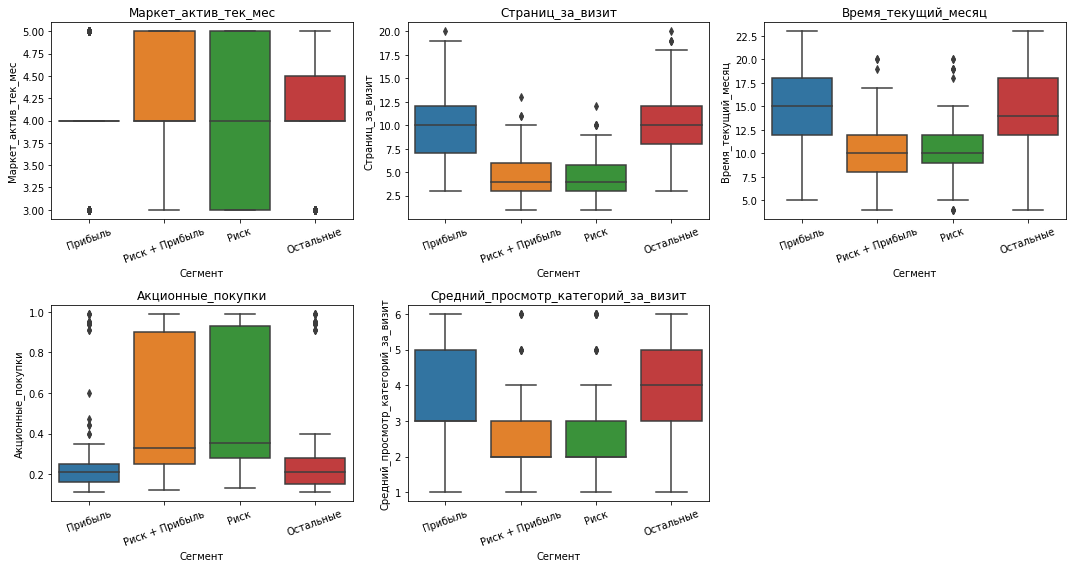

In [54]:
# Отбор сегмента
segment_key = 'Риск + Прибыль'
segment_df = merged_profit_df[merged_profit_df['Сегмент'] == segment_key]

# Сравнение распределений ключевых признаков
key_features = ['Маркет_актив_тек_мес', 'Страниц_за_визит', 'Время_текущий_месяц',
                'Акционные_покупки', 'Средний_просмотр_категорий_за_визит']

#  Числовой анализ — сравнение средних значений по сегментам
print("Сравнение средних значений по сегментам:")
display(merged_profit_df.groupby('Сегмент')[key_features].mean().T)

# Построим boxplot по каждому признаку
plt.figure(figsize=(15, 8))
for i, col in enumerate(key_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=merged_profit_df, x='Сегмент', y=col, order=['Прибыль', 'Риск + Прибыль', 'Риск', 'Остальные'])
    plt.title(f'{col}')
    plt.xticks(rotation=20)

plt.tight_layout()
plt.show()

Числовой анализ сегмента «Риск + Прибыль»

- Маркет_актив_тек_мес	4.05 / 3.99	Маркетинговая активность сохраняется, клиенты пока вовлечены.
- Страниц_за_визит	4.30 / 9.83	Значительно ниже — интерес к сайту ослабевает.
- Время_текущий_месяц	10.04 / 14.63 Клиенты проводят меньше времени на сайте.
- Акционные_покупки	0.49 / 0.24 Очень хорошо реагируют на акции — есть потенциал для удержания.
- Средний_просмотр_категорий_за_визит	2.41 / 3.57 Узкий интерес — интересуются меньшим количеством категорий.

Вывод:

Сегмент «Риск + Прибыль» показывает признаки снижающегося вовлечения:

меньше страниц, меньше времени, меньше охват категорий,

но хорошо откликается на акции — это ключ к удержанию.

Это ключевая группа, потому что она:

- приносит высокую прибыль;

- имеет высокую вероятность снижения активности.

Графический анализ сегмента «Риск + Прибыль»

- Страниц_за_визит
«Риск + Прибыль» медиана — почти как у «Риск», наименьшая среди всех групп.
Это означает, что клиенты просматривают мало страниц при визите на сайт.
Явный сигнал: низкая вовлечённость с контентом/товарами.

- Время_текущий_месяц
«Риск + Прибыль» тратят меньше времени на сайте, чем «Прибыль» и «Остальные». Медиана явно ниже. 
Снижается интерес меньше сессий или меньше времени в каждой.

- Средний_просмотр_категорий_за_визит
Этот сегмент также показывает наименьшее количество категорий, что указывает на: узкий интерес, незаинтересованность в ассортименте, возможно, отсутствие рекомендаций. Потенциальный повод активировать через персонализацию/новинки.

- Акционные_покупки
Интересно: у «Риск + Прибыль» высокие значения — почти как у «Риск».
Это означает, что они реагируют на акции, и это — точка воздействия. Хорошо воспринимают скидки, это — рычаг для удержания.

- Маркет_актив_тек_мес
Значение медианы чуть ниже, чем у «Прибыль», но выше, чем у «Риск». Поведение пока есть, но оно уже ослабевает.

**Бизнес-предложения по удержанию сегмента**

1. Email/Push-уведомления с напоминанием о брошенных товарах в корзине.

У сегмента высокая доля неоплаченных продуктов.

2. Индивидуальные предложения по акциям.

Сегмент активно реагирует на акционные предложения — можно предложить дополнительные бонусы, кэшбек или персональные скидки.

3. Ретаргетинг через соцсети и рекламу.

Учитывая падение активности на сайте, важно вернуть внимание клиента.

4. Улучшение рекомендаций.

Подборка товаров на основе предыдущих заказов/поисков для быстрого попадания в интерес.

**Вывод:**

Сегмент «Риск+Прибыль» — это ключевая целевая аудитория для удержания, так как сочетает в себе высокую прибыльность и риск ухода. Анализ поведения показывает снижение вовлечённости при сохранённой чувствительности к скидкам.
Таргетированные маркетинговые кампании и работа с барьерами (корзина, поиск) помогут удержать этих клиентов и увеличить LTV.

### Сделайте выводы о сегментах:
- какой сегмент вы взяли для дополнительного исследования
- какие предложения вы сделали и почему

**Выбранный сегмент для дополнительного анализа:**

Сегмент «Риск+Прибыль» — клиенты с высокой вероятностью снижения активности (вероятность > 0.7) и высокой прибыльностью (выше медианы по прибыли). 

**Почему выбран именно этот сегмент:**
    
- Финансово значимый: потери таких клиентов напрямую влияют на выручку компании.

- Поведение клиентов указывает на потенциальный отток: снижение вовлечённости, меньше времени на сайте, меньше страниц за визит.

- Высокая реакция на акции: есть возможность быстро вернуть интерес с помощью маркетинга.

**Сделанные предложения по удержанию:**

- Ремаркетинг на основе акций. Продвигать персонализированные скидки, акции и бонусные предложения — это эффективный триггер для сегмента.

- Коммуникация о брошенных корзинах. Автоматические напоминания через email/push-уведомления с CTA («докупите», «не забудьте» и т.п.).

- Улучшение пользовательского пути. Оптимизация поиска, рекомендаций и навигации, так как пользователи проводят меньше времени и меньше ищут товары.

- Экспресс-заказы и быстрый доступ к «любимым» товарам. Повысить удобство, чтобы ускорить процесс покупки и сократить риск ухода.

**Вывод:** 

Сегмент «Риск+Прибыль» — наиболее уязвим и при этом ценен для бизнеса. Вовремя принятые меры по удержанию этой группы помогут предотвратить потери выручки, повысить LTV и увеличить долю возвращающихся клиентов.

## Общий вывод
Сделайте общий вывод:
- опишите задачу;
- опишите исходные данные и проведённую предобработку;
- напишите, что вы сделали для поиска лучшей модели;
- укажите лучшую модель;
- добавьте выводы и дополнительные предложения для выбранного сегмента покупателей.

**Общий вывод**

- Задача проекта

Цель проекта — разработать модель, способную прогнозировать снижение покупательской активности клиентов интернет-магазина. На основе предсказаний модели необходимо выделить ключевые клиентские сегменты и сформировать бизнес-стратегии по удержанию наиболее ценных клиентов с высоким риском оттока.

- Исходные данные и предобработка

В проекте использовались четыре источника данных:

market_df — поведенческие и маркетинговые признаки,

money_df — данные о выручке по месяцам,

time_df — время на сайте по месяцам,

profit_df — совокупная прибыльность клиентов.

- Основные этапы предобработки:

отобраны клиенты с покупками в минимум 3 различных месяцах;

таблицы объединены по id в формат широкой таблицы;

целевой признак: Покупательская_активность (1 — активность снизилась, 0 — сохранилась).

- Поиск и выбор модели

Обучены и сравнены 4 модели:

Logistic Regression

SVC

KNN

Decision Tree

Для каждой:

реализован индивидуальный Pipeline с ColumnTransformer;

выполнен подбор гиперпараметров с помощью GridSearchCV;

метрика оценки — ROC-AUC, устойчивая к дисбалансу классов.

- Лучшая модель

Лучший результат показала модель Logistic Regression (C = 0.01):

ROC-AUC = 0.912 на тестовой выборке

простая в интерпретации, устойчивая и стабильная

- Выбор финальной модели

В рамках проекта были протестированы четыре алгоритма классификации: Logistic Regression, SVC, KNN и Decision Tree.

Для каждого алгоритма:

был построен индивидуальный Pipeline с использованием ColumnTransformer;

осуществлён подбор гиперпараметров через GridSearchCV (cv=5);

качество моделей оценивалось по метрике ROC-AUC, как наиболее подходящей для задач с дисбалансом классов.

По результатам кросс-валидации наилучшее качество продемонстрировала модель SVC с ROC-AUC = 0.9148.

Соответственно, именно она была выбрана как финальная модель, поскольку отбор должен осуществляться на основании кросс-валидации, а не тестовой выборки — это позволяет избежать переобучения и переоценки результата.

После выбора модель была протестирована на отложенной тестовой выборке (25% от клиентов).

Финальное качество составило ROC-AUC = 0.9174, что подтверждает её устойчивость и способность обобщать.

Примечание: хотя модель Logistic Regression показала более высокое значение ROC-AUC на тесте (0.9251), она не была выбрана, так как выбор модели по тестовой выборке нарушает принципы честной оценки и может привести к утечке информации (data leakage).

Таким образом, модель SVC рекомендована для внедрения и последующего применения в системе принятия решений по удержанию клиентов.

- Выводы и предложения по ключевому сегменту

Сформирована сегментация клиентов по риск-профилю и прибыльности.

Выделен приоритетный сегмент — «Риск + Прибыль»:

клиенты с высокой прибылью, но высокой вероятностью оттока;

составляют 199 клиентов и несут высокий финансовый потенциал.

- Анализ показал:

они проводят меньше времени на сайте,

меньше просматривают страниц и категорий,

часто совершают акционные покупки,

проявляют признаки снижения интереса, но реагируют на стимулы.

- Предложения по удержанию сегмента «Риск + Прибыль»

Низкая вовлечённость - Персонализированные подборки, рекомендации
Брошенные товары - Push/email-напоминания
Зависимость от акций - Индивидуальные скидки, кэшбэк, программа лояльности
Мало времени на сайте - Быстрые сценарии покупок, мгновенные офферы
Недостаточная коммуникация - Увеличение охвата, персонализированные сообщения

В результате проделанной работы построена интерпретируемая и точная модель, разработан подход к сегментации, а также предложены конкретные шаги для снижения оттока и увеличения жизненной ценности клиента.